# Classification

## Introduction

In this notebook we will look at explicit probabilistic approaches to classification in which we seek to infer something about the distribution of our data, before constructing a classifier. This contrasts with the **Discriminant Classification** approach, in which we seek to learn the classification boundary directly. This sort of apporach is adopted in the case of the Support Vector Machine, for example, but we will not focus on it in this notebook.

Instead we'll take a look at **Discriminative Classification**, which we'll illustrate with Logistic and Probit Regression, and **Generative Classification**, which we'll illustrate with Naive Bayes, QDA and LDA. Along the way we'll talk about the different metrics that are appropriate for classification task.

For the most part we will focus on binary classification, but we will also briefly address the extension of these classifiers to the multi-class setting.

On the coding side we will use Python, Numpy, Pandas and Scikit-Learn, together with Scipy for some manual optimisations. Please note that the code is written to be transparent rather than elegant or efficient!

This notebook covers much of the same content as the accompanying **Discriminative Classification** and **Generative Classification** lectures, but in a format which is meant to be more interactive.

In [1]:
#Standard Python libraries for data and visualisation
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib as mpl
import sklearn as sk
import scipy as sp
#import imblearn as il
import ipywidgets as widgets

#Import plotting tools from matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

#Import models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier

#Import error metric
from sklearn.metrics import log_loss, confusion_matrix 
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

#Import data munging tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

#Import optimiser & norm from scipy
from scipy.optimize import minimize
from scipy.stats import norm

#Import tools from imbalanced-learn
#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.over_sampling import RandomOverSampler
#from imblearn.over_sampling import SMOTE

#Import a dataset
from sklearn.datasets import load_breast_cancer

#Import interact from ipywidgets
from ipywidgets import interact

## Imports & Formatting

Please do not change the cell below, where you will see a number of imports. All of these packages are relevant for the notebook and it is important that you get used to them. 
You can find more information in their respective documentations.

In [2]:
#Check library compatibilities
from platform import python_version

python_tested = '3.11.5'
np_tested = '1.24.3'
pd_tested = '2.0.3'
mpl_tested = '3.7.2'
sk_tested = '1.3.0'
sp_tested = '1.11.1'
widgets_tested = '8.0.4'

print('Version compatibility checks: \n')

if python_tested != python_version():
    print('Python version DISCREPANCY: Running ' + python_version() + '. Expected ' + python_tested)
else:
    print('Python version compatible: Running ' + python_version())
if np_tested != np.__version__:
    print('Numpy version DISCREPANCY: Running ' + np.__version__ + '. Expected ' + np_tested)
else:
    print('Numpy version compatible: Running ' + np.__version__)
if pd_tested != pd.__version__:
    print('Pandas version DISCREPANCY: Running ' + pd.__version__ + '. Expected ' + pd_tested)
else:
    print('Pandas version compatible: Running ' + pd.__version__)
if mpl_tested != mpl.__version__:
    print('Matplotlib version DISCREPANCY: Running ' + mpl.__version__ + '. Expected ' + mpl_tested)
else:
    print('Matplotlib version compatible: Running ' + mpl.__version__)
if sk_tested != sk.__version__:
    print('Sklearn version DISCREPANCY: Running ' + sk.__version__ + '. Expected ' + sk_tested)
else:
    print('Sklearn version compatible: Running ' + sk.__version__)
if sp_tested != sp.__version__:
    print('Scipy version DISCREPANCY: Running ' + sp.__version__ + '. Expected ' + sp_tested)
else:
    print('Scipy version compatible: Running ' + sp.__version__)
if widgets_tested != widgets.__version__:
    print('Ipywidgets version DISCREPANCY: Running ' + widgets.__version__ + '. Expected ' + widgets_tested)
else:
    print('Ipywidgets version compatible: Running ' + widgets.__version__)

Version compatibility checks: 

Python version compatible: Running 3.11.5
Numpy version compatible: Running 1.24.3
Pandas version compatible: Running 2.0.3
Matplotlib version compatible: Running 3.7.2
Sklearn version compatible: Running 1.3.0
Scipy version compatible: Running 1.11.1
Ipywidgets version compatible: Running 8.0.4


Please save the attached `.css` file as `styles/custom.css`, and run the following cell in order to retain notebook formatting.

In [3]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

Please run the cell below if you wish to collapse code segments and improve readability of the notebook. 

If, after this, you wish to display all code segments again click on the cell below, then click on the menu at the top of the notebook, select the `Cell` menu, then select `Current Outputs` and select `Clear`.

In [ ]:
%%html
<style>
div.input {
    display:none;
}
</style>

## Contents

[**0. Probabilistic Classification**](#section_ProbabilisticClassification)

[**1. Discriminative Classification**](#section_DiscriminativeClassification)

[**2. Generative Classification**](#section_GenerativeClassification)

[**3. Multinomial Classification**](#section_MultinomialClassification)

[**4. Evaluation Metrics**](#section_Metrics)

[**5. Data Imbalance**](#section_Imbalance)

<a id='section_ProbabilisticClassification'></a>
## 0. Probabilistic Classification

In **Classification** we seek to learn a **mapping**, $f$, between a collection of input features, $\mathbf{x} = [1, x_1, \dots, x_m]^T \in \mathbb{R}^{m+1}$ and a discrete output label. $y$.

If we are dealing with **binary classification** then we often characterise $y \in \{0, 1\}$.

As usual, we will learn in the context of $n$ training examples by $\mathcal{S} = \{(\mathbf{x}^{(i)}, y^{(i)}) \}_{i=1}^n$.

In **probabilistic classification** we assume that $\mathbf{x}$ is the outcome of a random variable $\boldsymbol{\mathcal{X}}$, while $y$ is the outcome of a random variable $\mathcal{Y}$. And we seek the **Bayes Optimal Classifier**, $f^*$, which we can be shown to be that classifier which is specified as follows:
	\begin{align*}
		f^*(\mathbf{x}) =&\begin{cases} 
			& 1 \quad \mbox{if} \quad  p_{\mathcal{Y}}(y=1 \vert \mathbf{x}) \geq t \\ 
		  	& 0 \quad \mbox{if} \quad  p_{\mathcal{Y}}(y=1 \vert \mathbf{x}) < t
		\end{cases}
	\end{align*}
Where $t$ is some **threshold** which is appropriate to the **cost matrix** for the learning environment at hand.

A cost matrix encodes the cost of errors associated with misclassification - if $c_{01}$ denotes the cost of misclassifying a point labelled $y=1$, and $c_{10}$ denotes the cost of misclassifying a point labelled $y=0~$ then: 

<table style="width:30%; font-size: 15px">
  <tr>
  <tr style="height:50px; border-bottom: solid">
    <th style="width:70%; border-right: solid"></th>
    <th style="width:70%; vertical-align:center; text-align:center; border-right: solid; border-width: thin">$y=0$</th>
    <th style="width:70%; vertical-align:center; text-align:center">$y=1$</th>
  </tr>
  <tr style="height:50px; border-bottom: solid; border-bottom-width: thin">
    <th style="width:70%; vertical-align:center; text-align:center; border-right: solid">$f(\mathbf{x})=0$</th>
    <td style="width:70%; vertical-align:center; background-color: rgba(189, 231, 189, 0.6); border-right: solid; text-align:center; border-width: thin">$0$</td>
    <td style="width:70%; vertical-align:center; background-color: rgba(255, 182, 179, 0.6); text-align:center">$c_{01}$</td>
  </tr>
  <tr>
  <tr style="height:50px">
    <th style="width:70%; vertical-align:center; text-align:center; border-right: solid">$f(\mathbf{x})=1$</th>
    <td style="width:70%; vertical-align:center; background-color: rgba(255, 182, 179, 0.6); text-align:center; border-right: solid; border-width: thin">$c_{10}$</td>
    <td style="width:70%; vertical-align:center; background-color: rgba(189, 231, 189, 0.6); text-align:center">$0$</td>
  </tr>
</table>

For such a cost matrix, it can be shown that $t = \frac{c_{10}}{c_{10} + c_{01}}$ (Try to prove this yourself).

For much of this notebook we'll assume balanced cost matrices, in which case $t=0.5$.

$p_{\mathcal{Y}}(y=1 \vert \mathbf{x})$ is the posterior distribution of $y$ conditional on $\mathbf{x}$ - in particular for binary classification it is characterised by an **inhomogeneous Bernoulli distribution**, and our learning task in this setting boils down to learning the parameterisation of such a distribution given model assumptions.

Broadly there are two ways of learning this posterior distribution: Directly, in which case we are adopting **discriminative classification** or indirectly, in which case we are adopting **generative classification**.

<a id='section_DiscriminativeClassification'></a>
## 1. Discriminative Classification

In discriminative classification we seek to learn a function which can directly model $p_{\mathcal{Y}}(y=1 \vert \mathbf{x})$.

What sort of function might make sense for this purpose? Ones which have a range in the interval $[0, 1]$, and different classification techniques are associated with different choices of such functions.

Let's begin by considering **Logistic Regression**.

### Logistic Regression
In Logistic Regression we model $p_{\mathcal{Y}}(y=1 \vert \mathbf{x})$ using a suitable parameterised **logistic sigmoid** function:
\begin{equation*}
    p_{\mathcal{Y}}(y=1 \vert \mathbf{x}) = \frac{1}{1 + e^{-\mathbf{w} \cdot \mathbf{x}}}
\end{equation*}
Where $\mathbf{w} = [w_0, w_1, \dots, w_m]^T \in \mathbb{R}^{m+1}$ is some weight vector to be learned.

How do we learn this weight vector? In the usual setting we seek to learn this via **maximum likelihood estimation**, in which case we can show that in th context of logistic regression our learning problem becomes one in which we seek to maximise the following, **log-likelihood**, function:
\begin{align*}
   \mathsf{L} &= \sum_{i=1}^n \ln \left( p_{\mathcal{Y}}(y^{(i)} \vert \mathbf{x}^{(i)} \right) \\  
   &= \sum_{i=1}^n  y^{(i)} \ln \left( p_{\mathcal{Y}}(y^{(i)}=1 \vert \mathbf{x}^{(i)}) \right) 
   + (1 - y^{(i)}) \ln \left( 1 - p_{\mathcal{Y}}(y^{(i)}=1 \vert \mathbf{x}^{(i)})  \right) \\
   &= \sum_{i=1}^n  y^{(i)} \mathbf{w} \cdot \mathbf{x}^{(i)} -\ln \left(1+ e^{\mathbf{w} \cdot \mathbf{x}^{(i)}} \right)
\end{align*}
Here the second line is the binary loss metric know as the **log-loss** or **binary cross entropy**.

Specialising to the logistic sigmoid posterior yields the third line, and it can be shown that this function is convex and a numerical procedure (such as gradient descent) will, in most circumstances, deliver us to a globally optimial solution.

Let's demonstrate logistic regression in action with some toy data. For ease of visualisation, we'll deal with 2-d attributes so that $\mathbf{x} = [1, x_{1}, x_{2}]^T$ and $\mathbf{w} = [w_{0}, w_{1}, w_{2}]^T$. 

Let's generate some data for two different classes, each drawn from a different multivariate Gaussian with the same covariance matrix, but different means. We'll assume that the data is evenly distributed across classes.

In [4]:
#Function to generate 2-dimensional data based on Bernoulli / MVG data generation
def generate_2d_data(rnd_seed, delta, num_points, theta_0,
                     mu_0, sigma_0, mu_1, sigma_1):
    np.random.seed(rnd_seed)

    num_points_0 = round(theta_0 * num_points)
    num_points_1 = num_points - num_points_0

    #Class y=0 data
    x_0_train = np.random.multivariate_normal(mu_0, sigma_0, num_points_0) + 0.5*delta*np.ones((num_points_0,2))
    y_0_train = np.zeros(num_points_0).reshape(num_points_0,1)

    #Class y=1 data
    x_1_train = np.random.multivariate_normal(mu_1, sigma_1, num_points_1) - 0.5*delta*np.ones((num_points_1,2))
    y_1_train = np.ones(num_points_1).reshape(num_points_1,1)

    return x_0_train, x_1_train, y_0_train, y_1_train

#Generate data
num_points=50
delta = 0
#MVG parameters
#Class y=0
theta_0 = 0.5
sig_10 = 1.1
sig_20 = 1.1
rho_120 = 0.0
#Class y=0
sig_11 = sig_10
sig_21 = sig_20
rho_121 = rho_120

mu_0 = np.array([1.50,
                 1.25])
mu_1 = np.array([-1.0,
                 -1.0])
sigma_0 = np.array([[sig_10**2,             rho_120*sig_10*sig_20],
                    [rho_120*sig_10*sig_20, sig_20**2]])
sigma_1 = np.array([[sig_11**2,             rho_121*sig_11*sig_21],
                    [rho_121*sig_11*sig_21, sig_21**2]])


x_0_train, x_1_train, y_0_train, y_1_train = generate_2d_data(rnd_seed=42, delta=delta, num_points=num_points,
                                                              theta_0=theta_0,
                                                              mu_0=mu_0, sigma_0=sigma_0,
                                                              mu_1=mu_1, sigma_1=sigma_1)
X_train = np.r_[x_0_train, x_1_train]
y_train = np.r_[y_0_train, y_1_train].reshape(np.shape(y_0_train)[0] + np.shape(y_1_train)[0], )

     
#We will be re-using the plotting figure layout, so let's make a function to do this to avoid clutter later.
def make_layout():
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xlabel('$x_1$', fontsize=14)
    ax.set_ylabel('$x_2$', fontsize=14, rotation = 0)
    ax.grid()
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)
    return fig,ax

<div class=question>
<b>Exercise:</b>

1. Use `make_layout` to plot the data. Mark green circles for points with class label $y=0$, and red crosses for points with class label $y=1$:
    
2. Also observe the code we have implemented to plot the 'ground truth' discriminant boundary. Can you see what motivates this?
</div>

<div class=answer>
<b>Answer:</b>

The data is generated from two separated MVG's and the boundary is developed with this data generating process in mind by setting the posterior distributions for each class equal to one another.

</div>

<IPython.core.display.Javascript object>


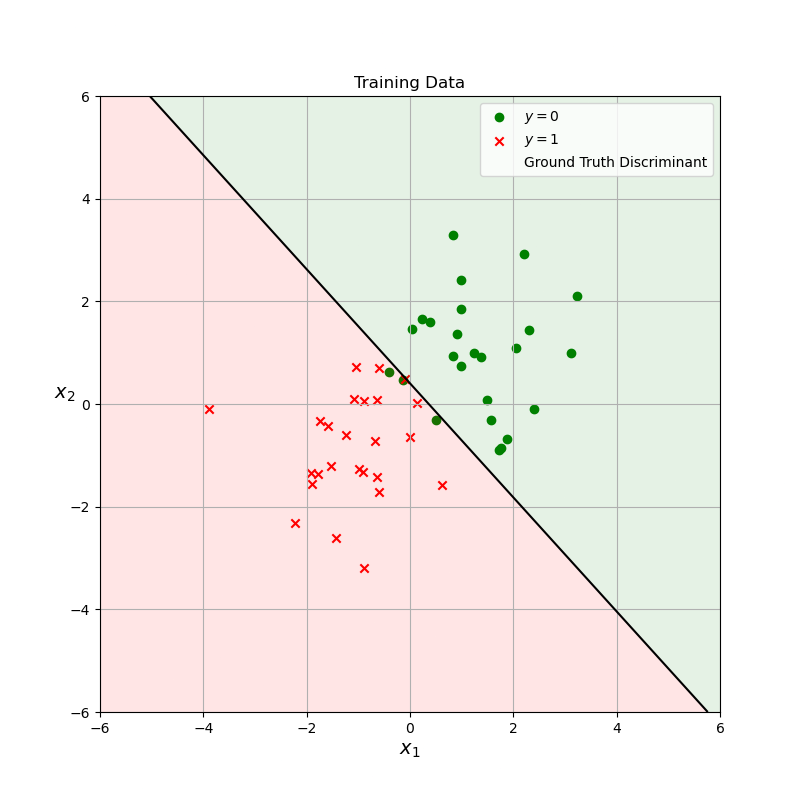

In [5]:
#Generate ground truth discriminant boundary function
def generate_ground_truth(delta, theta_0, mu_0, sigma_0, mu_1, sigma_1):
    x1_plot = np.linspace(-6, 6, 100)
    x2_plot = np.linspace(-6, 6, 100)
    xx1, xx2 = np.meshgrid(x1_plot, x2_plot)
    y_grid = np.zeros([x1_plot.size,x2_plot.size])
    mu0 = mu_0 + 0.5 * delta
    mu1 = mu_1 - 0.5 * delta
    for r in range(0,x1_plot.size):
        for c in range(0,x2_plot.size):
            x = np.array([x1_plot[r],x2_plot[c]]).reshape(1,2)
            quad1 = 0.5 * np.matmul(np.matmul(x.reshape(1,2), np.linalg.inv(sigma_0)), x.reshape(2,1))[0][0]
            quad2 = - 0.5 * np.matmul(np.matmul(x.reshape(1,2), np.linalg.inv(sigma_1)), x.reshape(2,1))[0][0]
            lin1  = - np.matmul(x.reshape(1,2), np.matmul(np.linalg.inv(sigma_0), mu0))[0]
            lin2  =   np.matmul(x.reshape(1,2), np.matmul(np.linalg.inv(sigma_1), mu1))[0]
            const1 = + 0.5 * np.log(np.linalg.det(sigma_0)/np.linalg.det(sigma_1)) + np.log((1-theta_0)/theta_0)
            const2 = 0.5 * np.matmul(mu0.reshape(1,2), np.matmul(np.linalg.inv(sigma_0), mu0))[0] 
            const3 = - 0.5 * np.matmul(mu1.reshape(1,2), np.matmul(np.linalg.inv(sigma_1), mu1))[0]
            y_grid[c,r] = quad1 + quad2 + lin1 + lin2 + const1 + const2 + const3
    return xx1, xx2, y_grid

#Ex 1
fig, ax = make_layout()
ax.scatter(x_0_train[:,0], x_0_train[:,1], color='green', label='$y=0$')
ax.scatter(x_1_train[:,0], x_1_train[:,1], color='red', marker='x', label='$y=1$')

#Ex 2
#Plot discriminant boundary
xx1, xx2, y_grid = generate_ground_truth(delta=delta, theta_0=theta_0, 
                                         mu_0=mu_0, sigma_0=sigma_0, 
                                         mu_1=mu_1, sigma_1=sigma_1)
true_disc = ax.contour(xx1, xx2, y_grid, [0], colors='black')
true_disc.collections[0].set_label('Ground Truth Discriminant')
true_disc_contourf_y1 = ax.contourf(xx1, xx2, y_grid, levels=[0,1000], colors='red', alpha=0.1)
true_disc_contourf_y0 = ax.contourf(xx1, xx2, y_grid, levels=[-1000,0], colors='green', alpha=0.1)

ax.legend()
ax.set_title('Training Data', fontsize=12)

plt.show()

<div class=question>
<b>Exercise:</b>

Let's run Logistic Regression on this data and plot the discriminant boundary learned together with a visualisation of the logistic sigmoid function which we are using to model the posterior probability.
    
1. Invoke and `fit` the the Scikit-Learn `LogisticRegression` model with an appropriate `solver` setting, with `penalty` set according to the outcome of the '$\ell_2$ norm regulariser' checkbox and with `fit_intercept=True` (since we are dealing with a bias term).

2. Use the `coef_` method to generate the weights, and stor them in `w_1` and `w_2`.
    
3. Inspect the code below - note in particular the implementation of a 'numerically stable sigmoid function'. Why do you think we implemented the sigmoid in this way rather than more directly?
</div>

<div class=answer>
<b>Answer:</b>

3. To avoid overflow.
    \begin{equation}
        \frac{1}{1 + e^{-\mathbf{w} \cdot \mathbf{x}}} = \frac{e^{\mathbf{w} \cdot \mathbf{x}}}{1 + e^{\mathbf{w} \cdot \mathbf{x}}}
    \end{equation}

    $e^{\mathbf{w} \cdot \mathbf{x}}$ will overflow when $\mathbf{w} \cdot \mathbf{x}$ is positive.

    $e^{-\mathbf{w} \cdot \mathbf{x}}$ will overflow when $\mathbf{w} \cdot \mathbf{x}$ is negative.

</div>

<IPython.core.display.Javascript object>


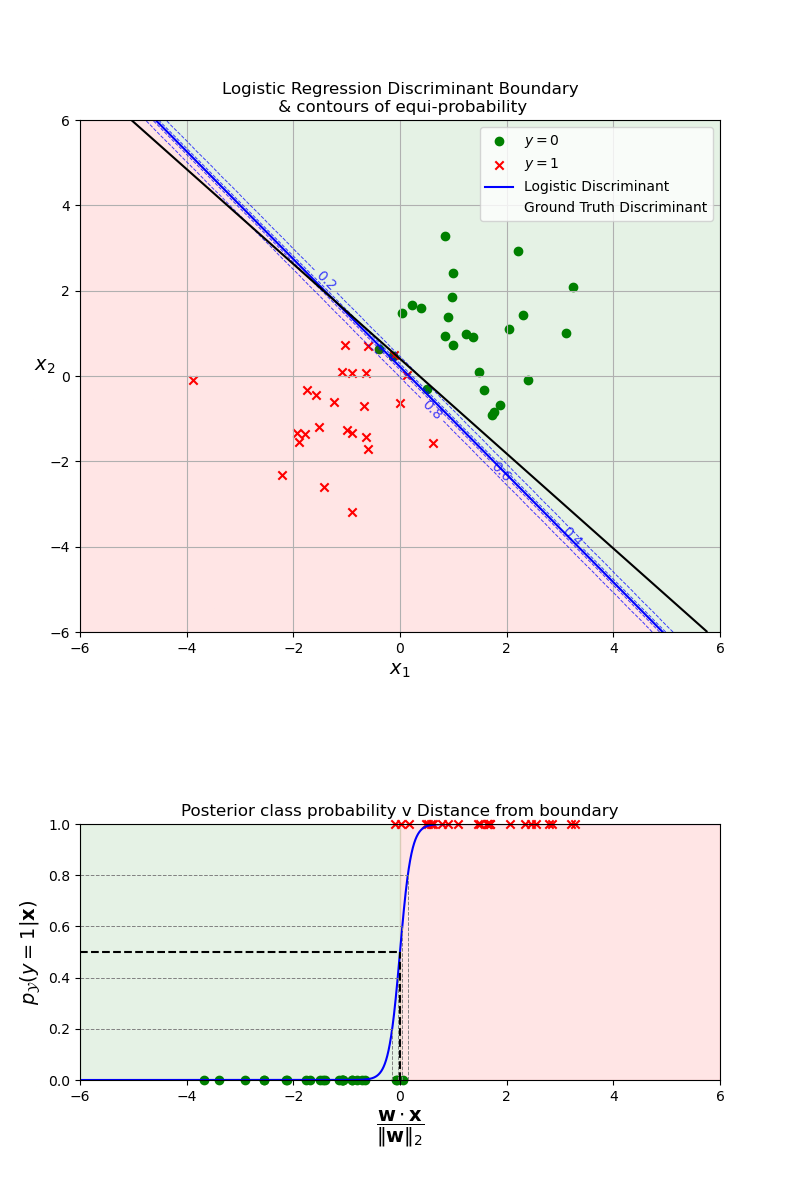

interactive(children=(FloatSlider(value=0.0, description='$\\delta$', max=1.0, min=-1.0, step=0.25), Checkbox(…

In [6]:
#Run animated plots of the outputs
plt.close('all')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,12), gridspec_kw={'height_ratios': [8, 4]})

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    hspace=0.5)
    
def plot_2d_LogisticRegression(delta, checkbox):
    if checkbox == True:
        penalty = 'l2'
    else:
        penalty = None
    x_0_train, x_1_train, y_0_train, y_1_train = generate_2d_data(rnd_seed=42, delta=delta, num_points=num_points,
                                                                  theta_0=theta_0,
                                                                  mu_0=mu_0, sigma_0=sigma_0,
                                                                  mu_1=mu_1, sigma_1=sigma_1)
    X_train = np.r_[x_0_train, x_1_train]
    y_train = np.r_[y_0_train, y_1_train].reshape(np.shape(y_0_train)[0] + np.shape(y_1_train)[0], )
    
    #Train Logistic Regression model
    # Ex 1
    lr = LogisticRegression(solver = 'lbfgs', penalty=penalty, fit_intercept=True, tol = 1e-9, max_iter = 100000)
    lr.fit(X_train, y_train)
    
    # Ex 2
    w_0 = lr.intercept_[0]
    w_1 = lr.coef_[0][0]
    w_2 = lr.coef_[0][1]
    w_vec = np.array([w_0,w_1,w_2]).reshape(-1,1)
    w_norm = np.linalg.norm((w_vec).reshape(-1,1))
    
    #PLOT 1: Discriminant Boundary
    ax1.clear()
    ax1.grid()
    ax1.set_xlabel('$x_1$', fontsize=14)
    ax1.set_ylabel('$x_2$', fontsize=14, rotation = 0)
    ax1.set_xlim(-6, 6)
    ax1.set_ylim(-6, 6)

    #Plot training points
    ax1.scatter(x_0_train[:,0], x_0_train[:,1], color='green', label='$y=0$')
    ax1.scatter(x_1_train[:,0], x_1_train[:,1], color='red', marker='x', label='$y=1$')

    #Plot Discriminant Boundary
    x1_plot = np.linspace(-6, 6, 100)
    x2_plot = np.linspace(-6, 6, 100)

    p = 0.5
    x2_plot_bound = (1/w_2)*(np.log(p/(1-p)) - w_0 - w_1*x1_plot)
    ax1.plot(x1_plot,x2_plot_bound, color='blue', label = 'Logistic Discriminant')

    #Plot Probability Contours
    x1_grid, x2_grid = np.meshgrid(x1_plot, x2_plot)
    y_grid = lr.predict_proba(np.c_[x1_grid.ravel(), x2_grid.ravel()])
    y_grid = y_grid[:, 1].reshape(x1_grid.shape)
    contours = ax1.contour(x1_grid, x2_grid, y_grid, levels = 4, colors = 'blue', 
                           linewidths=0.7, alpha=0.75, linestyles='dashed')
    ax1.clabel(contours, contours.levels, inline=True)
    true_disc_contourf_y1 = ax1.contourf(x1_grid, x2_grid, y_grid, levels=[0.5,1], colors='red', alpha=0.1)
    true_disc_contourf_y0 = ax1.contourf(x1_grid, x2_grid, y_grid, levels=[0,0.5], colors='green', alpha=0.1)
       
    #Plot Ground Truth Discriminant
    xx1, xx2, y_grid = generate_ground_truth(delta=delta, theta_0=theta_0, 
                                         mu_0=mu_0, sigma_0=sigma_0, 
                                         mu_1=mu_1, sigma_1=sigma_1)
    true_disc = ax1.contour(xx1, xx2, y_grid, [0], colors='black')
    true_disc.collections[0].set_label('Ground Truth Discriminant')

    ax1.legend()
    ax1.set_title('Logistic Regression Discriminant Boundary\n & contours of equi-probability', fontsize=12)
    
       
    #PLOT 2: Sigmoid Function
    ax2.clear()
    ax2.set_xlabel('$\dfrac{\mathbf{w} \cdot \mathbf{x}}{\Vert \mathbf{w} \Vert_2}$', fontsize=14)
    ax2.set_ylabel('$p_{\mathcal{Y}}(y=1 | \mathbf{x})$', fontsize=14, rotation = 90)
    min_dist = -6
    max_dist = 6
    ax2.set_xlim(min_dist, max_dist)
    ax2.set_ylim(0, 1.0)

    #Plot Sigmoid
    dist_plot = np.linspace(min_dist, max_dist, 10000)
    x = dist_plot*w_norm
    ### Numerically stable sigmoid function ###
    prob_plot=np.zeros(10000)
    for x_i in x:
        if x_i >= 0:
            z_i = np.exp(-x_i)
            prob_plot[np.where(x==x_i)] = 1 / (1 + z_i)
        else:
        # if x is less than zero then z will be small, denom can't be
        # zero because it's 1+z.
            z_i = np.exp(x_i)
            prob_plot[np.where(x==x_i)] = z_i / (1 + z_i)
    
    ax2.plot(dist_plot, prob_plot, color='blue', linewidth=1.5)

    #Plot lines of probability
    ax2.plot([min_dist,0], [0.5,0.5] ,color='black', linestyle='dashed')
    ax2.vlines(x=[0], ymin=0, ymax=0.5 ,color='black', linestyle='dashed')
    ax2.plot([min_dist,np.log(0.8/(1-0.8)) / w_norm], [0.8,0.8] ,color='gray', linewidth=0.7, linestyle='dashed')
    ax2.vlines(x=[np.log(0.8/(1-0.8))]/w_norm, ymin=0, ymax=0.8 ,color='gray', linewidth=0.7, linestyle='dashed')
    ax2.plot([min_dist,np.log(0.6/(1-0.6))  /w_norm], [0.6,0.6] ,color='gray', linewidth=0.7, linestyle='dashed')
    ax2.vlines(x=[np.log(0.6/(1-0.6))]/w_norm, ymin=0, ymax=0.6 ,color='gray', linewidth=0.7, linestyle='dashed')
    ax2.plot([min_dist,np.log(0.4/(1-0.4))  /w_norm], [0.4,0.4] ,color='gray', linewidth=0.7, linestyle='dashed')
    ax2.vlines(x=[np.log(0.4/(1-0.4))]/w_norm, ymin=0, ymax=0.4 ,color='gray', linewidth=0.7, linestyle='dashed')
    ax2.plot([min_dist,np.log(0.2/(1-0.2))  /w_norm], [0.2,0.2] ,color='gray', linewidth=0.7, linestyle='dashed')
    ax2.vlines(x=[np.log(0.2/(1-0.2))]/w_norm, ymin=0, ymax=0.2 ,color='gray', linewidth=0.7, linestyle='dashed')

    ax2.axvspan(0, max_dist, alpha=0.1, color='red')
    ax2.axvspan(min_dist, 0, alpha=0.1, color='green')

    #Plot distances of training points
    ax2.scatter(np.matmul(w_vec.T, np.c_[np.ones((x_0_train.shape[0], 1)), x_0_train].T )/w_norm, 
                np.zeros([np.shape(y_0_train)[0],1]), color='green', clip_on=False)
    ax2.scatter(np.matmul(w_vec.T, np.c_[np.ones((x_1_train.shape[0], 1)), x_1_train].T )/w_norm, 
                np.ones([np.shape(y_1_train)[0],1]), color='red', marker='x', clip_on=False)

    ax2.set_title('Posterior class probability v Distance from boundary', fontsize=12)
    
plt.show()

#INTERACT
int_plot = interact(plot_2d_LogisticRegression, 
                    delta = widgets.FloatSlider(description = '$\delta$', value=0, min=-1, max=1, step=0.25), 
                    checkbox = widgets.Checkbox(description = '$\ell_2$ norm regulariser', value=False))

<div class=question>
<b>Exercise:</b>

We can play with the separation between our $y=1$ and $y=0$ classes using the $\delta$ widget which effects the distance between the centres of the two mutlivariate Gaussians which we used to generate the toy data.

We can also see the effect of adding a regulariser to our Logistic Regression model objective using the checkbox which we have included (the hyperparameter is set to some default number though that can be changed to - see the `LogisticRegression` model documentation for further details). 

Try changing the distance between the clusters and turning regularisation on and off. What do you notice?
    
In particular what happens when the data becomes <b>linearly separable</b>.
</div>

<div class=answer>
<b>Answer:</b>

As the distance between clusters increases then sigmoid function tends to the heaviside.
    
However, switching on regularistion mitigates this over confidence and softens the heaviside once more.
    
</div>

### Probit Regression

Now let's consider a slightly different form of discriminative classification, **probit regression**. Here we model the posterior probabilty with the cumulative distribution function of a standard normal distribution:
\begin{equation*}
    p_{\mathcal{Y}}(y \vert \mathbf{x}) = \boldsymbol{\Phi}(\mathbf{w} \cdot \mathbf{x} )
\end{equation*}

As before, we seek to learn $\mathbf{w}$ by maximising the log-likelihood function:
\begin{align*}
   \mathsf{L} &= \sum_{i=1}^n \ln \left( p_{\mathcal{Y}}(y^{(i)} \vert \mathbf{x}^{(i)} \right) \\  
   &= \sum_{i=1}^n  y^{(i)} \ln \left( \boldsymbol{\Phi}(\mathbf{w} \cdot \mathbf{x}^{(i)} ) \right) 
   + (1 - y^{(i)}) \ln \left( 1 - \boldsymbol{\Phi}(\mathbf{w} \cdot \mathbf{x}^{(i)} ) \right)
\end{align*}

We can seek to optimise this using SciPy's `minimize` routine.

First we need to define the loss as a cost function. For this we can use Scikit-Learn's `log_loss` metric (which circumvents underflow by flooring probabilities at `eps`):

In [7]:
def cost_function(params, X, y):
    prob = norm.cdf(X.dot(params).reshape(-1,1))
    return log_loss(y, prob)

<IPython.core.display.Javascript object>


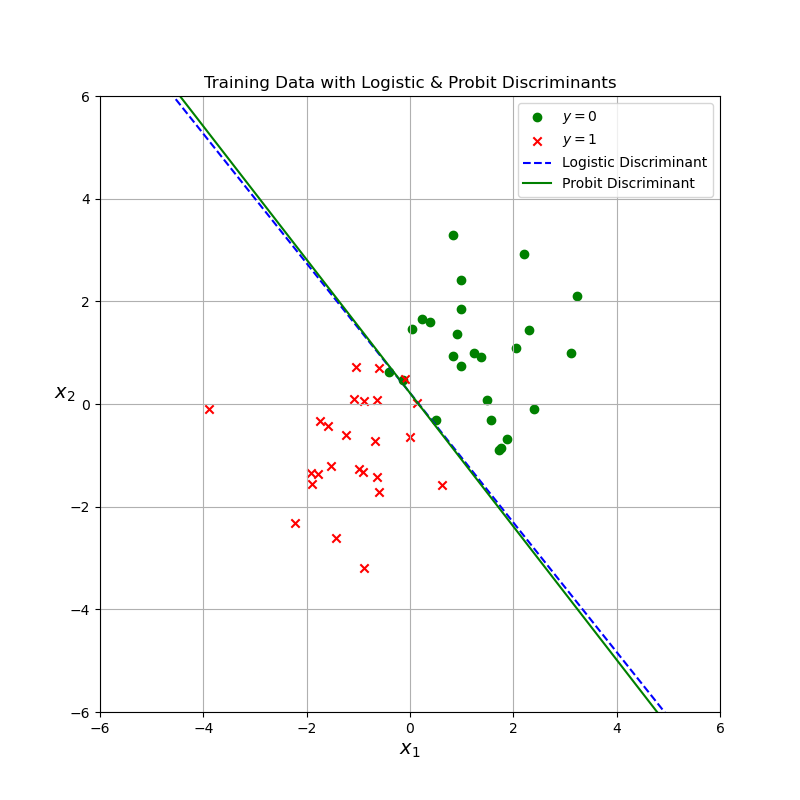

In [8]:
x_0_train, x_1_train, y_0_train, y_1_train = generate_2d_data(rnd_seed=42, delta=delta, num_points=num_points,
                                                                  theta_0=theta_0,
                                                                  mu_0=mu_0, sigma_0=sigma_0,
                                                                  mu_1=mu_1, sigma_1=sigma_1)
fig, ax = make_layout()

ax.scatter(x_0_train[:,0], x_0_train[:,1], color='green', label='$y=0$')
ax.scatter(x_1_train[:,0], x_1_train[:,1], color='red', marker='x', label='$y=1$')

#Plot Discriminant Boundary - logistic
lr = LogisticRegression(solver = 'lbfgs', penalty=None, fit_intercept=True, tol = 1e-9, max_iter = 100000)
lr.fit(X_train, y_train)

p=0.5
w_0 = lr.intercept_[0]
w_1 = lr.coef_[0][0]
w_2 = lr.coef_[0][1]
x1_plot = np.linspace(-6, 6, 100)
x2_plot_bound = (1/w_2)*(np.log(p/(1-p)) - w_0 - w_1*x1_plot)
ax.plot(x1_plot,x2_plot_bound, color='blue', linestyle='dashed',
        label = 'Logistic Discriminant')

#Plot Discriminant Boundary - probit
# Run the minimiser, with an initialisation of [0,0], since in this case w is 2-d.
output = minimize(cost_function, np.array([0,0,0]), 
                  args=(np.c_[np.ones((X_train.shape[0], 1)), X_train], y_train))

# Select the argmin from the outputs of 'minimize'.
w_probit = output.x.reshape(-1,1)

w_probit_0 = w_probit[0]
w_probit_1 = w_probit[1]
w_probit_2 = w_probit[2]
x2_plot_bound = (1/w_probit_2)*(norm.ppf(p) - w_probit_0 - w_probit_1*x1_plot)
ax.plot(x1_plot,x2_plot_bound, color='g',
        label = 'Probit Discriminant')

ax.legend()
ax.set_title('Training Data with Logistic & Probit Discriminants', fontsize=12)

plt.show()

Both forms of classification seem to yield similar boundaries. But now let's observe what happens when we add an outlier:

<IPython.core.display.Javascript object>


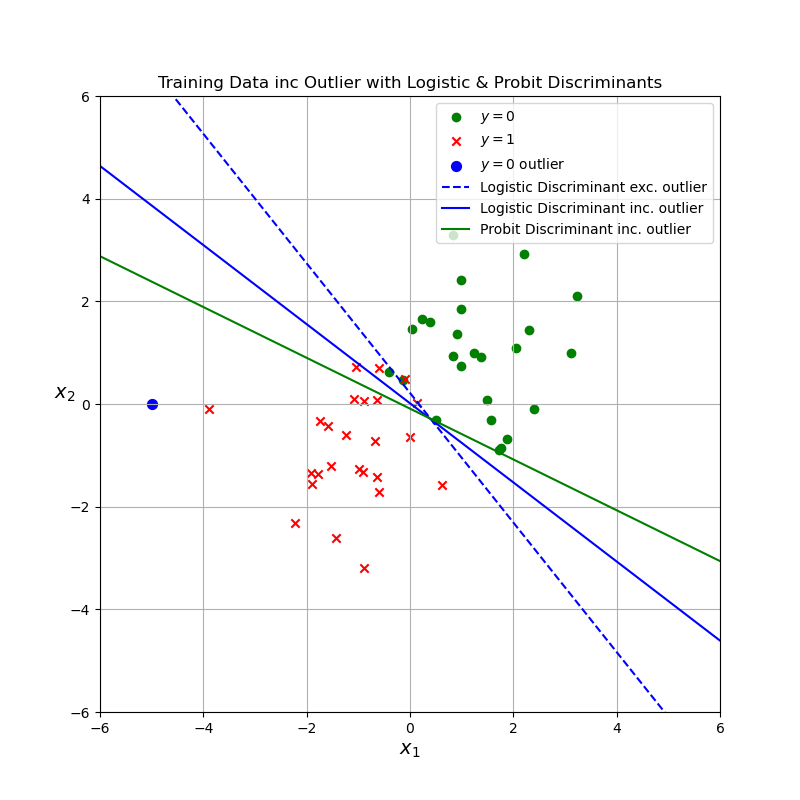

In [9]:
x_0_train, x_1_train, y_0_train, y_1_train = generate_2d_data(rnd_seed=42, delta=delta, num_points=num_points,
                                                                  theta_0=theta_0,
                                                                  mu_0=mu_0, sigma_0=sigma_0,
                                                                  mu_1=mu_1, sigma_1=sigma_1)
outlier = [-5, 0]

x_0_train_outlier = np.vstack((x_0_train,outlier))
y_0_train_outlier = np.vstack((y_0_train,0))

X_train_outlier = np.r_[x_0_train_outlier, x_1_train]
y_train_outlier = np.r_[y_0_train_outlier, y_1_train].reshape(np.shape(y_0_train_outlier)[0] 
                                                              + np.shape(y_1_train)[0], )

fig, ax = make_layout()

ax.scatter(x_0_train[:,0], x_0_train[:,1], color='green', label='$y=0$')
ax.scatter(x_1_train[:,0], x_1_train[:,1], color='red', marker='x', label='$y=1$')
ax.scatter(outlier[0], outlier[1], color='blue', marker='o', s=50, label="$y=0$ outlier")

#Plot Discriminant Boundary - original
lr = LogisticRegression(solver = 'lbfgs', penalty=None, fit_intercept=True, tol = 1e-9, max_iter = 100000)
lr.fit(X_train, y_train)

p=0.5
w_0 = lr.intercept_[0]
w_1 = lr.coef_[0][0]
w_2 = lr.coef_[0][1]
x1_plot = np.linspace(-6, 6, 100)
x2_plot_bound = (1/w_2)*(np.log(p/(1-p)) - w_0 - w_1*x1_plot)
ax.plot(x1_plot,x2_plot_bound, color='blue', linestyle='dashed',
        label = 'Logistic Discriminant exc. outlier')

#Plot Discriminant Boundary - outlier
lr = LogisticRegression(solver =  'lbfgs', penalty=None, fit_intercept=True, tol = 1e-9, max_iter = 100000)
lr.fit(X_train_outlier, y_train_outlier)

w_0 = lr.intercept_[0]
w_1 = lr.coef_[0][0]
w_2 = lr.coef_[0][1]
x2_plot_bound = (1/w_2)*(np.log(p/(1-p)) - w_0 - w_1*x1_plot)
ax.plot(x1_plot,x2_plot_bound, color='blue', 
        label = 'Logistic Discriminant inc. outlier')

#Plot Discriminant Boundary - probit
# Run the minimiser, with an initialisation of [0,0], since in this case w is 2-d.
output = minimize(cost_function, np.array([0,0,0]), 
                  args=(np.c_[np.ones((X_train_outlier.shape[0], 1)), X_train_outlier], y_train_outlier))

# Select the argmin from the outputs of 'minimize'.
w_probit = output.x.reshape(-1,1)

w_probit_0 = w_probit[0]
w_probit_1 = w_probit[1]
w_probit_2 = w_probit[2]
x2_plot_bound = (1/w_probit_2)*(norm.ppf(p) - w_probit_0 - w_probit_1*x1_plot)
ax.plot(x1_plot,x2_plot_bound, color='g',
        label = 'Probit Discriminant inc. outlier')

ax.legend()
ax.set_title('Training Data inc Outlier with Logistic & Probit Discriminants', fontsize=12)

plt.show()

Oh dear, just like OLS, both Logistic & Probit Regression seem sensitive to outliers, but this is particularly manifest in the latter case. 

Why is this?

Because the underlying distribution for Logistic Regression is the Logistic Distribution while that of Probit Regression is the Normal Distribution. The Logistic Distribution has more probability density in the tails than the Normal one, and hence is more able to accommodate outliers. Thus Logistic Regression will be more robust to oultiers than Probit Regression.

<div class=question>
<b>Exercise:</b>

Try changing the outlier so that it lies very far away from the boundary. What do you notice?
    
</div>

<div class=answer>
<b>Answer:</b>

For sufficiently high deviations from the boundary both probit and logistic regression will learn the same, corrupted, boundary
    
</div>

Now, let's move on to consider regression in the presence of multi-dimensional attributes:

### Multi-Dimensional Logistic Regression
The ideas we have been discussing can be  implemented in $m$-dimensions where $m>2$. In this case the discriminant boundary becomes an $m-1$ dimensional hyperplane. 

Let's illustrate this in three dimensions:

First we'll generate some 3d data, again from a couple of multivariate Gaussians.

Then we'll run `LogisticRegression` on the data.

And finally we'll plot the results:

<IPython.core.display.Javascript object>


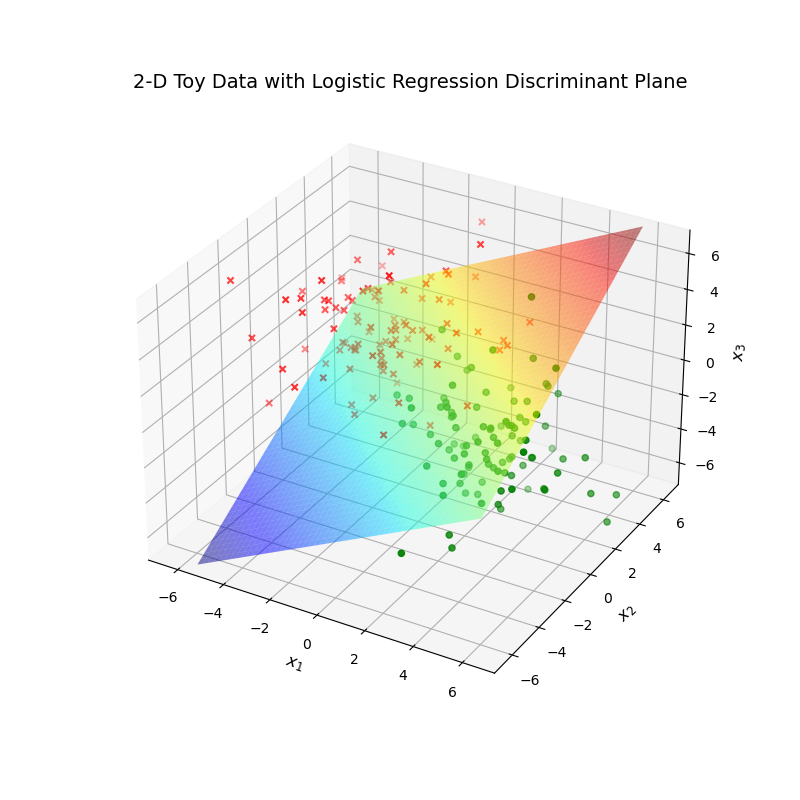

In [10]:
#Generate_3d_data:
np.random.seed(42)

num_points_0=100
num_points_1=100

#MVG parameters
sig_10 = 2
sig_20 = 2
sig_30 = 2
rho_120 = 0.0
rho_130 = 0.0
rho_230 = 0.0
mu_10 = 2
mu_20 = 2
mu_30 = -3
mu_11 = -1
mu_21 = -0.75
mu_31 = 4

sigma_0 = np.array([[sig_10**2,                 rho_120*sig_10*sig_20,         rho_130*sig_10*sig_30],
                    [rho_120*sig_10*sig_20,     sig_20**2,                    rho_230*sig_20*sig_30],
                    [rho_130*sig_10*sig_30,     rho_230*sig_20*sig_30,         sig_30**2]])
mu_0 = np.array([mu_10, mu_20, mu_30])
sigma_1 = sigma_0
mu_1 = np.array([mu_11, mu_21, mu_31]) 

#Class y=0 data
x_0_train = np.random.multivariate_normal(mu_0, sigma_0, num_points_0)
y_0_train = np.zeros(num_points_0).reshape(num_points_0,1)

#Class y=1 data
x_1_train = np.random.multivariate_normal(mu_1, sigma_1, num_points_1)
y_1_train = np.ones(num_points_1).reshape(num_points_1,1)

X_train = np.r_[x_0_train, x_1_train]
y_train = np.r_[y_0_train, y_1_train].reshape(np.shape(y_0_train)[0] + np.shape(y_1_train)[0], )


#Run Logistic Regression
lr = LogisticRegression(solver = 'lbfgs', penalty=None, fit_intercept=True, tol = 1e-9, max_iter = 100000)
lr.fit(X_train, y_train)

w_0 = lr.intercept_[0]
w_1 = lr.coef_[0][0]
w_2 = lr.coef_[0][1]
w_3 = lr.coef_[0][2]


#Plot training points and discriminant plane 
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1, projection="3d")

ax.clear()
ax.set_xlabel('$x_1$', fontsize=12)
ax.set_ylabel('$x_2$', fontsize=12)
ax.set_zlabel('$x_3$', fontsize=12)
ax.set_xlim(-7, 7)
ax.set_ylim(-7, 7)
ax.set_zlim(-7, 7)

#Plot training points
ax.scatter(x_0_train[:,0], x_0_train[:,1], x_0_train[:,2], color='green', label='$y=0$')
ax.scatter(x_1_train[:,0], x_1_train[:,1], x_1_train[:,2], color='red', marker='x', label='$y=1$')

#Plot disciminant plane
x1_train = np.linspace(-6,6,100).reshape(100,1)
x2_train = np.linspace(-6,6,100).reshape(100,1)
xx1_train, xx2_train = np.meshgrid(x1_train, x2_train)
xx3_train = -(1/w_3)*( w_0 + w_1 * xx1_train  + w_2 * xx2_train )
reg = ax.plot_surface(xx1_train, xx2_train, xx3_train, cmap=plt.cm.jet, alpha=0.5)

ax.set_title('2-D Toy Data with Logistic Regression Discriminant Plane', fontsize=14)
plt.show()

<a id='section_GenerativeClassification'></a>
## 2. Generative Classification

In generative classification we seek to learn a function which can **indirectly** model $p_{\mathcal{Y}}(y=1 \vert \mathbf{x})$ via Bayes' rule:
\begin{equation*}
    p_{\mathcal{Y}}(y=1 \vert \mathbf{x}) = \frac{p_{\mathcal{X}}(\mathbf{x} \vert y=1) p_{\mathcal{Y}}(y=1)}{p_{\mathcal{X}}(\mathbf{x})}
\end{equation*}
Because classification will involve a comparison of posterior probabilities and because the denominator in Bayes' rule is common to all classes, then in generative classification we seek to model only the numerator in this expression. 


The discriminant boundary is then formed from the set of points which satisfy:
\begin{equation*}
    p_{\mathcal{X}}(\mathbf{x} \vert y=1) p_{\mathcal{Y}}(y=1) = p_{\mathcal{X}}(\mathbf{x} \vert y=0) p_{\mathcal{Y}}(y=0)
\end{equation*}


$p_{\mathcal{Y}}(y=1) (= 1- p_{\mathcal{Y}}(y=0))$ is modelled as a Bernoulli distribution:
\begin{align*}
    p_{\mathcal{Y}}(y=0) &= 1 - \theta \\
    p_{\mathcal{Y}}(y=1) &= \theta
\end{align*}
Here $\theta$ is a parameter typically learned via maximum likelihood estimation to yield an estimator equal to the proportion of points labelled $y=1$ in the test set.


$p_{\mathcal{X}}(\mathbf{x} \vert y=1)$ and $p_{\mathcal{X}}(\mathbf{x} \vert y=0)$ are more difficult to handle, especially if the dimensionality of $\mathbf{x}$ is large, so we tend to make distributional assumptions about their forms in order to ease the task of estimating them.


For most of what follows we will assume that the attributes within $\mathbf{x}$ are all real-valued and that $p_{\mathcal{X}}(\mathbf{x} \vert y)$ can be modelled with a multivariate Gaussian:

\begin{align*}
    p_{\mathcal{X}}(\mathbf{x} \vert y=0) &= \mathcal{N}(\boldsymbol{\mu}_{0}, \boldsymbol{\Sigma}_{0}) \\
    p_{\mathcal{X}}(\mathbf{x} \vert y=1) &= \mathcal{N}(\boldsymbol{\mu}_{1}, \boldsymbol{\Sigma}_{1})
\end{align*}
Here $\boldsymbol{\mu}_{0}, \boldsymbol{\mu}_{1} \in \mathbb{R}^m$ and $\boldsymbol{\Sigma}_{0}, \boldsymbol{\Sigma}_{1} \in \mathbb{R}^{m \times m}$ are parameters that, again, are typically learned via maximum likelihood estimation.


We can derive the discriminant boundaries of such models as follows:
\begin{equation*}
		\theta 	\frac{1}{(2 \pi)^{m/2}} \frac{1}{\vert \boldsymbol{\Sigma}_1 \vert^{1/2}} \exp{\left( -\frac{1}{2} (\mathbf{x} - \boldsymbol{\mu}_1)^T \boldsymbol{\Sigma}_1^{-1} (\mathbf{x} - \boldsymbol{\mu}_1) \right)} = (1-\theta)\frac{1}{(2 \pi)^{m/2}} \frac{1}{\vert \boldsymbol{\Sigma}_0 \vert^{1/2}} \exp{\left( -\frac{1}{2} (\mathbf{x} - \boldsymbol{\mu}_0)^T \boldsymbol{\Sigma}_0^{-1} (\mathbf{x} - \boldsymbol{\mu}_0) \right)}
\end{equation*}


From which it follows that:
\begin{equation*}
		\mathbf{x}^{T}\mathbf{A}\mathbf{x} + \mathbf{b}^T \mathbf{x} + c = 0
\end{equation*}
Where:
\begin{align*}
    \mathbf{A} &= \frac{1}{2} \left( \boldsymbol{\Sigma}_1^{-1} - \boldsymbol{\Sigma}_0^{-1} \right) \\
    \mathbf{b} &=  \boldsymbol{\Sigma}_0^{-1} \boldsymbol{\mu}_{0} - \boldsymbol{\Sigma}_1^{-1}\boldsymbol{\mu}_{1} \\
    c &= \frac{1}{2}(\boldsymbol{\mu}_{1}^{T} \boldsymbol{\Sigma}_1^{-1} \boldsymbol{\mu}_{1}- \boldsymbol{\mu}_{0}^{T} \boldsymbol{\Sigma}_0^{-1} \boldsymbol{\mu}_{0}) + \ln \left(\frac{1-\theta}{\theta}\right) + \ln \left( \frac{{\vert\boldsymbol{\Sigma}_1\vert}^{1/2}}{{\vert\boldsymbol{\Sigma}_0\vert}^{1/2}} \right)
\end{align*}

So the boundaries are the **level set** of a **quadratic function** associated with the value zero. Depending on the parameterisation of our distributions, this yields a surprisingly rich range of boundaries, as illustrated below:

<IPython.core.display.Javascript object>


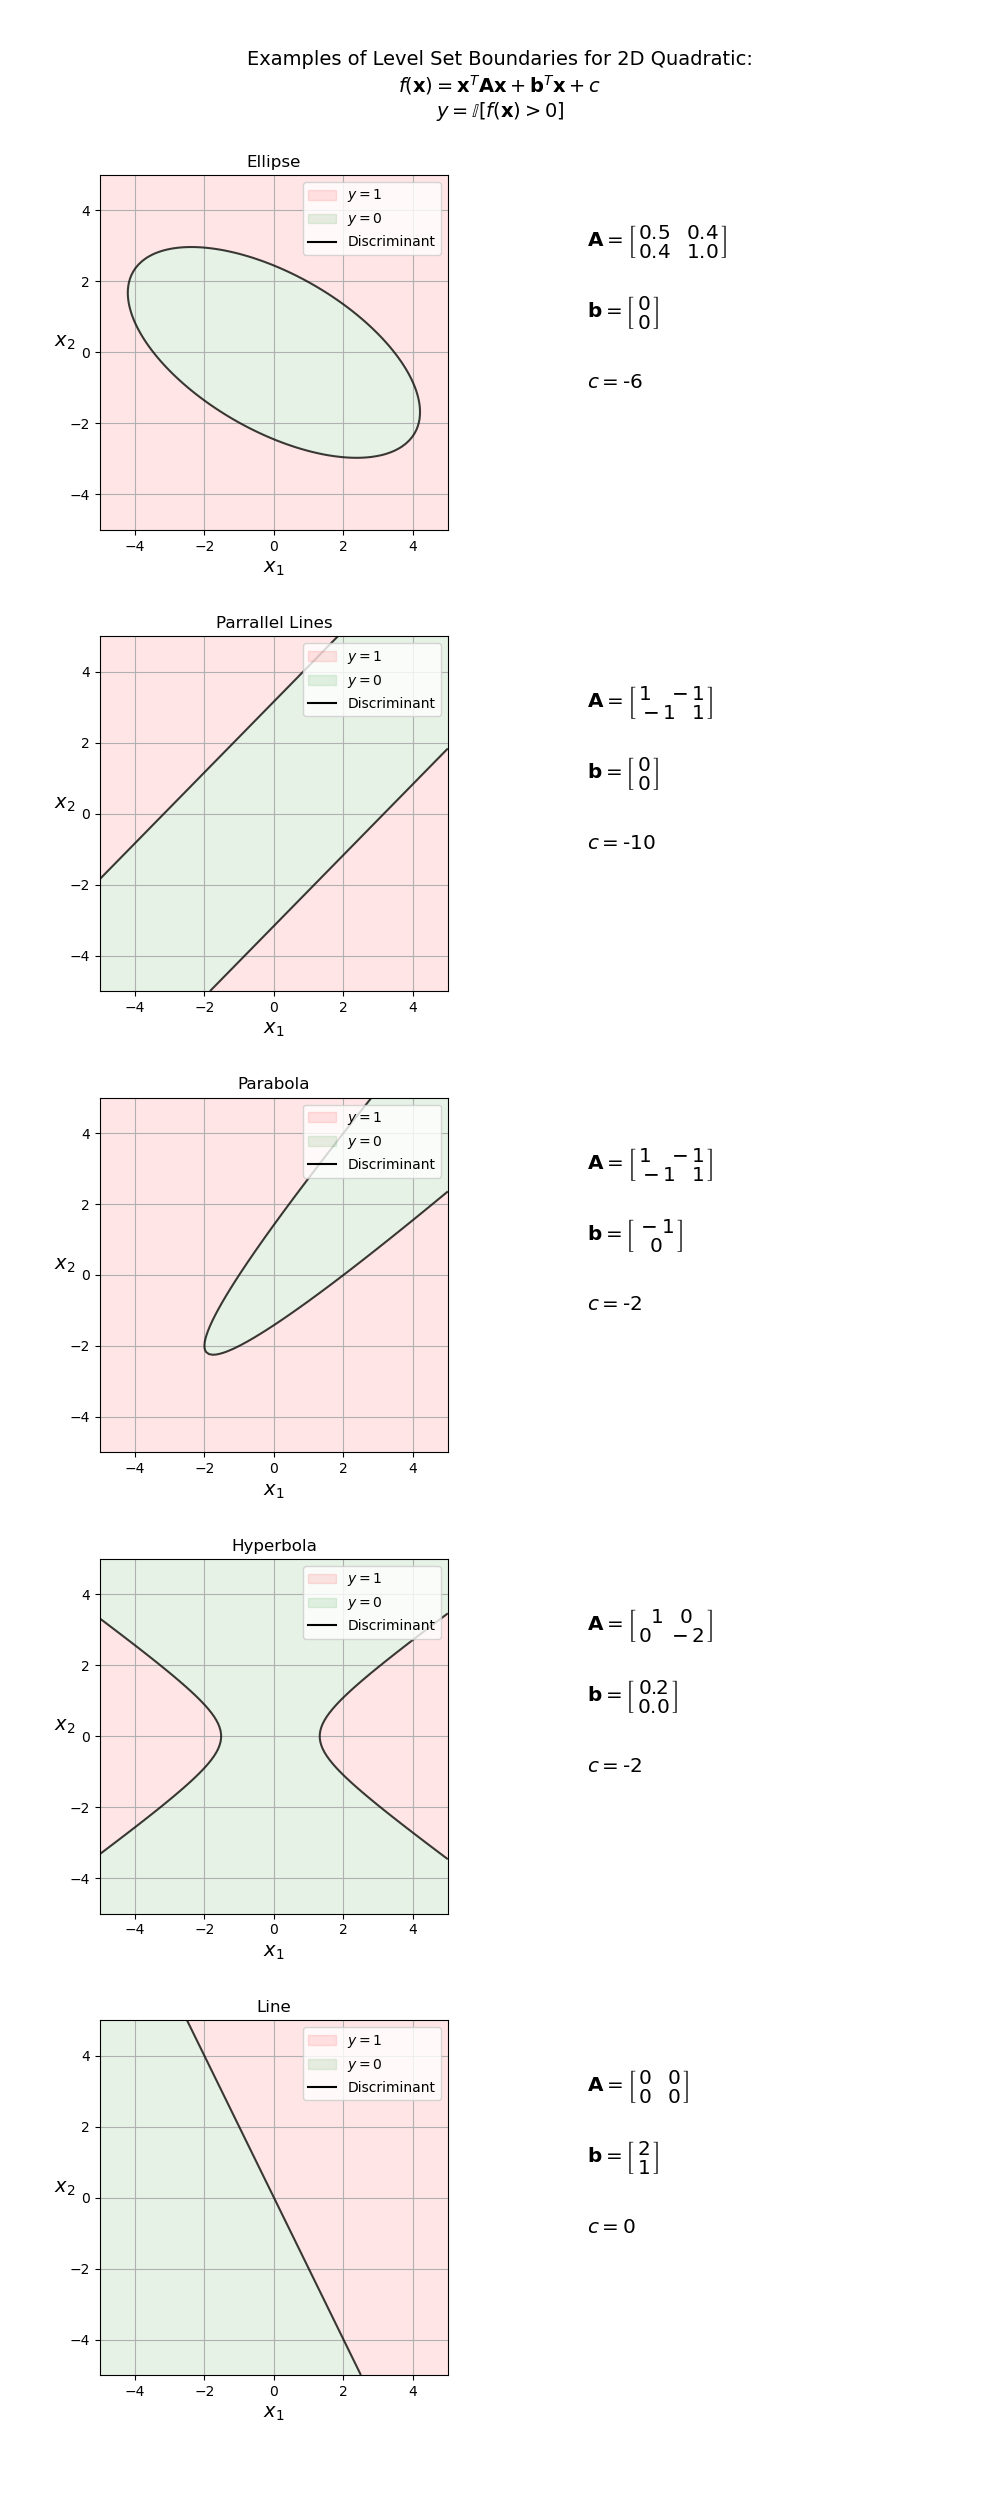

In [11]:
def quadratic_level_sets(A, b, c, x1_plot, x2_plot):
    y_grid = np.zeros([x1_plot.size,x2_plot.size])
    for row in range(0,x1_plot.size):
        for col in range(0,x2_plot.size):
            x = np.array([x1_plot[row],x2_plot[col]]).reshape(1,2)
            quad =  np.matmul(np.matmul(x.reshape(1,2), A), x.reshape(2,1))[0][0]
            lin  =  np.dot(x.reshape(1,2), b)[0]
            const = c
            y_grid[col,row] = quad + lin + const
    return y_grid

#Ex 1
plt.close('all')

fig = plt.figure(figsize=(10,25))
plt.subplots_adjust(left=0.1,
                    bottom=0.05, 
                    right=0.9, 
                    top=0.93, 
                    hspace=0.3,
                    wspace=0.3)

gs=GridSpec(5,2) # 5 rows, 2 columns
ax1a=fig.add_subplot(gs[0,0])
ax1b=fig.add_subplot(gs[0,1])
ax2a=fig.add_subplot(gs[1,0])
ax2b=fig.add_subplot(gs[1,1])
ax3a=fig.add_subplot(gs[2,0])
ax3b=fig.add_subplot(gs[2,1])
ax4a=fig.add_subplot(gs[3,0])
ax4b=fig.add_subplot(gs[3,1])
ax5a=fig.add_subplot(gs[4,0])
ax5b=fig.add_subplot(gs[4,1])

dict_names = {
                'Plot1': {
                            'A': np.array([[0.5,     0.4],
                                           [0.4,     1]]),
                            'b': np.array([0, 0]),
                            'c': -6 ,
                            'name': 'Ellipse'
                        },
                'Plot2': {
                            'A': np.array([[1,     -1],
                                           [-1,     1]]),
                            'b': np.array([0, 0]),
                            'c': -10, 
                            'name': 'Parrallel Lines'
                        },
                'Plot3': {
                            'A': np.array([[1,     -1],
                                           [-1,     1]]),
                            'b': np.array([-1, 0]),
                            'c': -2, 
                            'name': 'Parabola'
                        },
                'Plot4': {
                            'A': np.array([[1,     0],
                                           [0,     -2]]),
                            'b': np.array([0.2, -0]),
                            'c': -2, 
                            'name': 'Hyperbola'
                        },
                'Plot5': {
                            'A': np.array([[0,     0],
                                           [0,     0]]),
                            'b': np.array([2, 1]),
                            'c': 0, 
                            'name': 'Line'
                        }}

min_dist = -5
max_dist = 5
x1_plot = np.linspace(min_dist, max_dist, 100)
x2_plot = np.linspace(min_dist, max_dist, 100)
xx1, xx2 = np.meshgrid(x1_plot, x2_plot)

red_patch = mpatches.Patch(color='red', alpha=0.1, label='$y=1$')
green_patch = mpatches.Patch(color='green', alpha=0.1, label='$y=0$')
line = Line2D([0], [0], label='Discriminant', color='k')

i=0
axb = [ax1b,ax2b,ax3b,ax4b,ax5b]
for ax in [ax1a,ax2a,ax3a,ax4a,ax5a]:
    i=i+1
    ax.set_xlim(min_dist, max_dist)
    ax.set_ylim(min_dist, max_dist)
    ax.set_xlabel('$x_1$', fontsize=14)
    ax.set_ylabel('$x_2$', fontsize=14, rotation = 0)
    ax.grid()
    A = dict_names['Plot'+str(i)]['A']
    b = dict_names['Plot'+str(i)]['b']
    c = dict_names['Plot'+str(i)]['c']
    name = dict_names['Plot'+str(i)]['name']
    y_grid = quadratic_level_sets(A, b, c, x1_plot, x2_plot)
    quadratic_contourf_y1 = ax.contourf(xx1, xx2, y_grid, levels=[0,1000], colors='red', alpha=0.1)
    quadratic_contourf_y0 = ax.contourf(xx1, xx2, y_grid, levels=[-1000,0], colors='green', alpha=0.1)
    quadratic_contour = ax.contour(xx1, xx2, y_grid, levels=[0], colors='black', alpha=0.75)
    ax.legend(handles=[red_patch,green_patch,line])
    ax.set_title(name, fontsize=12)
    
    ax = axb[i-1]
    ax.set_axis_off()
    A_txt = '$\genfrac {[} {]} {0} {0} {\,'+ str(A[0,0]) + '\;\;\;' + str(A[0,1]) + '} {\,'+ str(A[1,0]) + '\;\;\;' + str(A[1,1]) + '}$'
    b_txt = '$\genfrac {[} {]} {0} {0} {\,'+ str(b[0]) + '} {\,'+ str(b[1]) + '}$'
    c_txt = str(c)
    ax.text(0.1,0.8,'$\mathbf{A} = $' + A_txt, fontsize = 'x-large')
    ax.text(0.1,0.6,'$\mathbf{b} = $' + b_txt, fontsize = 'x-large')
    ax.text(0.1,0.4,'$c = $' + c_txt, fontsize = 'x-large')
    
fig.suptitle('Examples of Level Set Boundaries for 2D Quadratic:\n' +
             '$f(\mathbf{x}) = \mathbf{x}^T \mathbf{A} \mathbf{x} + \mathbf{b}^T \mathbf{x} + c$ \n' +
             '$y = \mathbb{I}[f(\mathbf{x})>0]$'
             , fontsize=14)

plt.show()

<div class=question>
<b>Exercise:</b>

Think back to the **Calculus** lecture. For each of the plots above, Which kind of quadratic function does it relate to?
    
How would the parameterisation need to change in each of the plots above so that the red $y=1$ region and the green $y=0$ regions were switched?
</div>

<div class=answer>
<b>Answer:</b>
    
1. **Ellipse**: Strictly Convex Quadratic
2. **Parrallel Lines**: Convex and Bounded Quadratic
3. **Parabola**: Convex and Unbounded Quadratic
4. **Hyperbola**: Non-Convex Quadratic (Saddle)
5. **Line**: Plane

Sign change of $\mathbf{A}, \mathbf{b}, c$
</div>

Depending on the assumptions we make with respect to the covariance structure of the class conditional multivariate Gaussians (MVG), we will develop a different classifier: 

More assumptions will ease our inference task at the expense of restricting the variety of discriminant boundaries that can be learned to some subset of those illustrated above. 


We will consider three classifiers which emerge from different assumptions: **Linear Discriminant Analysis**, **Gaussian Naive Bayes**, and **Quadratic Discriminant Analysis**:


### Linear Discriminant Analysis
In the Linear Discriminant Analysis (LDA) approach to probabilistic modelling we assume that the class conditional covariances are equal to one another:

\begin{equation*}
    \boldsymbol{\Sigma}_0 = \boldsymbol{\Sigma}_1
\end{equation*}
Thus we have $1 + 2m + m(m+1)/2$ parameters to learn, emerging from the Bernoulli, MVG means, and the common MVG covariances.

Because the covariances will cancel, the discriminant boundary available in this model is restricted to 'lines'.


### Gaussian Naive Bayes
In the Naive Bayes approach to probabilistic modelling we assume that the class conditional attributes are independent of one another:
\begin{equation*}
    p_{\mathcal{X}}(\mathbf{x} \vert y) = \prod_{j=1}^{m} p_{\mathcal{X}}(x_{j} \vert y)
\end{equation*}
We can then model the class conditional attribute distribution with whatever distribution we deem appropriate - for example, Multinomial for categorical outcomes, Poisson for ordered natural number outcomes etc. We can even mix and match these distributions for different attributes within our attribute vector. 

Right now we'll concentrate on continuous attribute outcomes, modelled with univariate Gaussians which leads to Gaussian Naive Bayes (GNB).

But because of the nature of the Gaussian distribution we know that the joint distribution of a set of independent Gaussian distributions is mutlivariate Gaussian, with a diagonal covariance matrix:

\begin{align*}
    \boldsymbol{\Sigma}_0 = \mbox{diag}(\sigma_{10}^{2}, \dots, \sigma_{m0}^{2})\\
    \boldsymbol{\Sigma}_1 = \mbox{diag}(\sigma_{11}^{2}, \dots, \sigma_{m1}^{2})\\
\end{align*}
Thus we have $1 + 2m + 2m$ parameters to learn, emerging from the Bernoulli, MVG means, and the MVG variances.

Here it is possible to learn all of the boundaries above, but the first four will be restricted somewhat so that the the foci of the shapes are axis aligned (this flows from the fact that the MVG's which characterise the underlying class contingent distributions are axis-aligned ellipses - because of the Naive Bayes assumption).


### Quadratic Discriminant Analysis
In the Quadratic Discriminant Analysis (QDA) approach to probabilistic modelling we make no restrictions on the form that the class conditional covariances can take.

This is the most general approach and means that we have $1 + 2m + m(m+1)$ parameters to learn, emerging from the Bernoulli, MVG means, and MVG covariances.

Here it is possible to learn all of the boundaries above.


### Comparison

Let's re-call our original data-generating distribution which we introduced at the beginning of this notebook, and which induced a linear boundary (check that this makes sense following the discussion of the level sets of quadratic functions above).

Let's use this distribution to generate some training and validation data, which we will then use to train and evaluate Scikit-learn implementations of Logistic Regression, LDA, GNB, and QDA using **misclassification loss** as our evaluation measure:

In [12]:
#Generate data
delta = 0
#MVG parameters
#Class y=0
theta_0 = 0.5
sig_10 = 1.1
sig_20 = 1.1
rho_120 = 0.0
#Class y=1
sig_11 = sig_10
sig_21 = sig_20
rho_121 = rho_120

##For use in subsequest exercise - Scenario 1
#Class y=1
#sig_11 = 2
#sig_21 = 4
#rho_121 = 0.4

##For use in subsequest exercise - Scenario 2
##Class y=1
#sig_11 = 0.5
#sig_21 = 4
#rho_121 = 0.4

mu_0 = np.array([1.50,
                 1.25])
mu_1 = np.array([-1.0,
                 -1.0])
sigma_0 = np.array([[sig_10**2,             rho_120*sig_10*sig_20],
                    [rho_120*sig_10*sig_20, sig_20**2]])
sigma_1 = np.array([[sig_11**2,             rho_121*sig_11*sig_21],
                    [rho_121*sig_11*sig_21, sig_21**2]])

<div class=question>
<b>Exercise:</b>

1. Use `generate_2d_data` to create 12,000 data points, using `rnd_seed=42`. Then use `train_test_split` to create a training set containing 2,000 data points, and a validation set containing 10,000 data points.

2. Complete the code below in which we loop through increasingly large subsets of the training data, which we use to train a set of classifiers, which we are then used to predict the labels of a validation set, off the back of which we calculate a validation accuracy score for the classifier. In particular make use of the Scikit-Learn functions: `GaussianNB`, `LinearDiscriminantAnalysis`, and `QuadraticDiscriminantAnalysis`.
</div>

In [13]:
# Ex 1
num_points_train_max=500
num_points_valid=10000

x_0_train, x_1_train, y_0_train, y_1_train = generate_2d_data(rnd_seed=42, delta=delta, 
                                                              num_points=num_points_train_max+num_points_valid,
                                                              theta_0=theta_0,
                                                              mu_0=mu_0, sigma_0=sigma_0,
                                                              mu_1=mu_1, sigma_1=sigma_1)

X = np.r_[x_0_train, x_1_train]
y = np.r_[y_0_train, y_1_train].reshape(np.shape(y_0_train)[0] + np.shape(y_1_train)[0], )

#Split Data into training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=num_points_valid/(num_points_valid+num_points_train_max), 
                                                      random_state = 42)

# Ex 2
num_points_expts = np.arange(10,num_points_train_max,50)
accuracy = np.zeros([len(num_points_expts),4])
i=0
for elem in num_points_expts:
    i = i + 1
    num_points=elem
    X_train_elem = X_train[0:num_points,:]
    y_train_elem = y_train[0:num_points]
    
    #Logistic Regression
    lr = LogisticRegression(solver = 'lbfgs', penalty=None, fit_intercept=True, tol = 1e-9, max_iter = 100000)
    lr.fit(X_train_elem, y_train_elem)
    y_valid_predict = lr.predict(X_valid)
    accuracy[i-1,0] = accuracy_score(y_valid, y_valid_predict)
  
    #Ex 2a
    #GNB
    gnb = GaussianNB()
    gnb.fit(X_train_elem, y_train_elem)
    y_valid_predict = gnb.predict(X_valid)
    accuracy[i-1,1] = accuracy_score(y_valid, y_valid_predict)

    #Ex 2b
    #LDA
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train_elem, y_train_elem)
    y_valid_predict = lda.predict(X_valid)
    accuracy[i-1,2] = accuracy_score(y_valid, y_valid_predict)

    #Ex 2c
    #QDA
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(X_train_elem, y_train_elem)
    y_valid_predict = qda.predict(X_valid)
    accuracy[i-1,3] = accuracy_score(y_valid, y_valid_predict)

misclassification_loss = np.round((1-accuracy)*100,2)

Now we'll use this data to plot boundaries for each of the classifiers for different subsets of the data, together with a validation set misclassification loss **learning curve**, which we'll use for comparison of the classifiers:

<IPython.core.display.Javascript object>


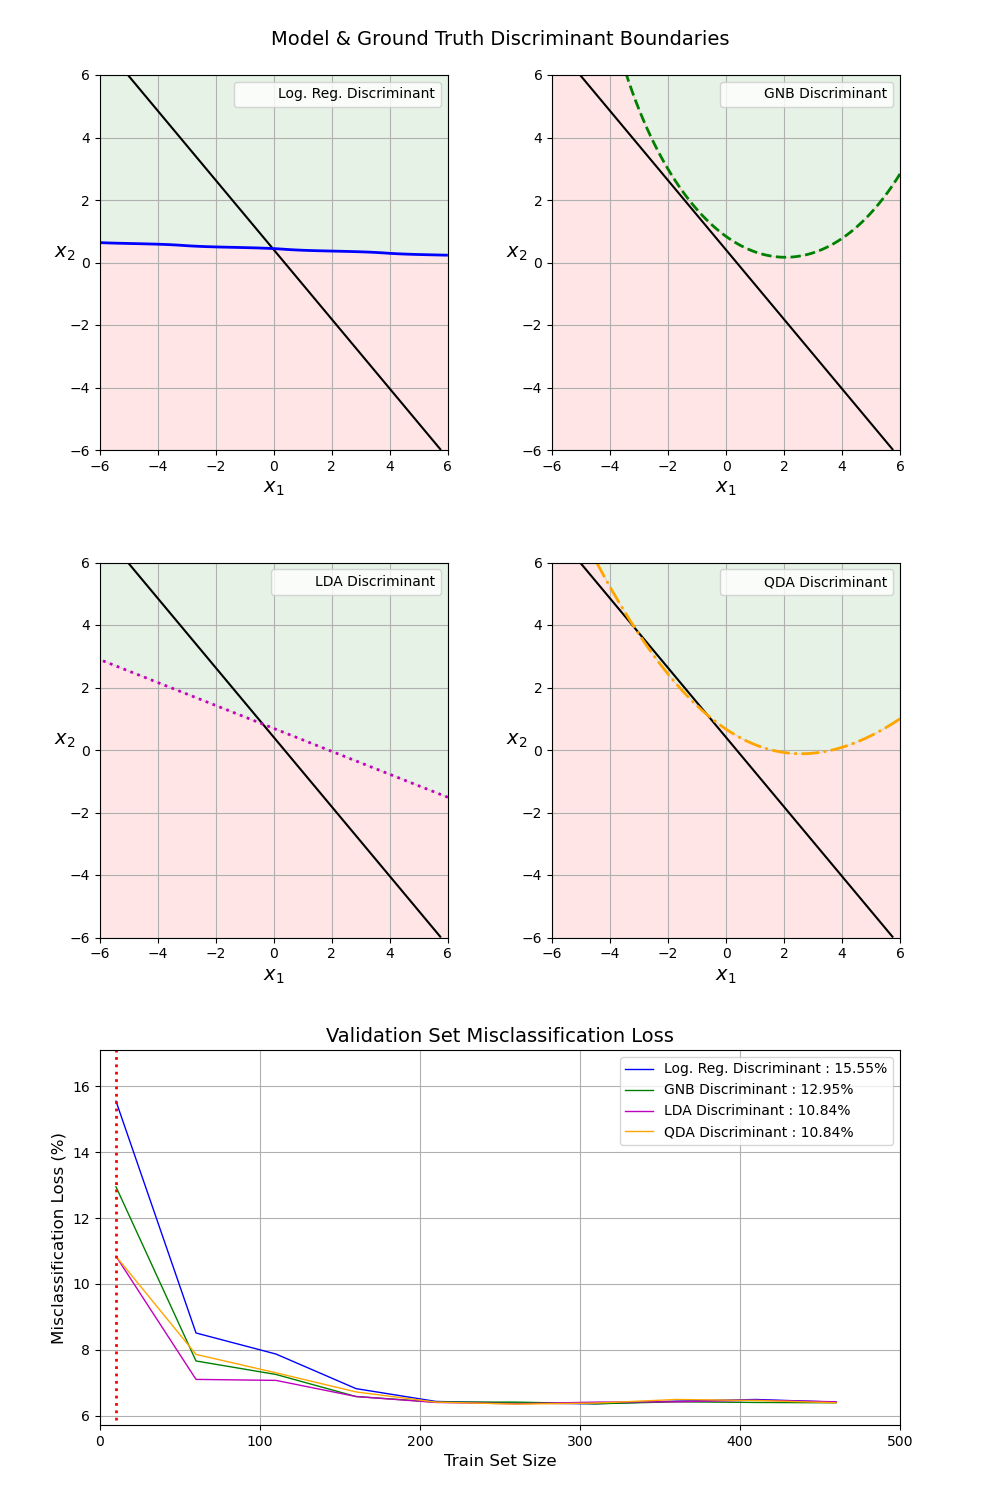

interactive(children=(Checkbox(value=False, description='Train Data'), Checkbox(value=False, description='Vali…

In [14]:
# Ex 2
#Run animated plots of the outputs
plt.close('all')
fig = plt.figure(figsize=(10,15))
plt.subplots_adjust(left=0.1,
                    bottom=0.05, 
                    right=0.9, 
                    top=0.95, 
                    hspace=0.3,
                    wspace=0.3)

gs=GridSpec(3,2) # 3 rows, 2 columns

ax1=fig.add_subplot(gs[0,0]) # First row, first column
ax2=fig.add_subplot(gs[0,1]) # First row, second column
ax3=fig.add_subplot(gs[1,0]) # Second row, first column
ax4=fig.add_subplot(gs[1,1]) # Second row, second column
ax5=fig.add_subplot(gs[2,:]) # Third row, span all columns

dict_names = {
                'Plot1': {
                            'model': LogisticRegression(solver = 'lbfgs', penalty=None, fit_intercept=True, 
                                                        tol = 1e-9, max_iter = 100000),
                            'label': 'Log. Reg. Discriminant',
                            'linestyle': 'solid',
                            'color': 'blue'
                        },
                'Plot2': {
                            'model': GaussianNB(),
                            'label': 'GNB Discriminant',
                            'linestyle': 'dashed',
                            'color': 'green'
                        },
                'Plot3': {
                            'model': LinearDiscriminantAnalysis(),
                            'label': 'LDA Discriminant',
                            'linestyle': 'dotted',
                            'color': 'm'
                        },
                'Plot4': {
                            'model': QuadraticDiscriminantAnalysis(),
                            'label': 'QDA Discriminant',
                            'linestyle': 'dashdot',
                            'color': 'orange'
                        }}

#Set up meshgrid for contour plots
min_dist = -6
max_dist = 6
xx1, xx2 = np.meshgrid(np.linspace(min_dist, max_dist, 100),
                       np.linspace(min_dist, max_dist, 100))

#Generate coordinates of Ground Truth Discriminant
xx1_, xx2_, y_grid = generate_ground_truth(delta=delta, theta_0=theta_0, 
                                         mu_0=mu_0, sigma_0=sigma_0, 
                                         mu_1=mu_1, sigma_1=sigma_1)

def plot_Disc_Plots(checkbox_0, checkbox_1, train_size):

    X_train_elem = X_train[0:train_size+1,:]
    y_train_elem = y_train[0:train_size+1]

    #PLOTS 1-5:
    #Set up environments
    for ax in [ax1,ax2,ax3,ax4]:
        ax.clear()
        ax.set_xlabel('$x_1$', fontsize=14)
        ax.set_ylabel('$x_2$', fontsize=14, rotation = 0)
        ax.set_xlim(min_dist, max_dist)
        ax.set_ylim(min_dist, max_dist)
        ax.grid()
    ax5.clear()
    ax5.set_xlabel('Train Set Size', fontsize=12)
    ax5.set_ylabel('Misclassification Loss (%)', fontsize=12, rotation = 90)
    ax5.set_xlim(0, num_points_train_max)
    ax5.set_ylim(0.9*np.min(misclassification_loss), 1.1*np.max(misclassification_loss))
    ax5.grid()
    
    #PLOTS 1-4:
    #Plot training & validation data
    for ax in [ax1,ax2,ax3,ax4]:
        #Plot Training Data
        if checkbox_0 == 1:
            ax.scatter(X_train_elem[y_train_elem==0,0], X_train_elem[y_train_elem==0,1], color='green', 
                       alpha=0.3)
            ax.scatter(X_train_elem[y_train_elem==1,0], X_train_elem[y_train_elem==1,1], color='red', 
                       marker='x', alpha=0.3)
        #Plot Validation Data
        if checkbox_1 == 1:
            ax.scatter(X_valid[y_valid==0,0], X_valid[y_valid==0,1], color='green', alpha=0.2)
            ax.scatter(X_valid[y_valid==1,0], X_valid[y_valid==1,1], color='red', marker='x', alpha=0.2)
    
    #PLOT 1-5:
    i=0
    for ax in [ax1,ax2,ax3,ax4]:
        #Ground Truth Contour
        ax.contour(xx1_, xx2_, y_grid, [0], colors='black')
        #Plot discriminants
        i=i+1
        model = dict_names['Plot'+str(i)]['model']
        label = dict_names['Plot'+str(i)]['label']
        color = dict_names['Plot'+str(i)]['color']
        linestyle = dict_names['Plot'+str(i)]['linestyle']
        model.fit(X_train_elem, y_train_elem)
        prob = model.predict_proba(np.c_[xx1.ravel(), xx2.ravel()])
        prob = prob[:, 1].reshape(xx1.shape)
        model_contour = ax.contour(xx1, xx2, prob, [0.5], colors=color, linestyles=linestyle, linewidths=2)
        model_contour.collections[0].set_label(label)
        model_contourf_y1 = ax.contourf(xx1, xx2, prob, levels=[0.5,1], colors='red', alpha=0.1)
        model_contourf_y0 = ax.contourf(xx1, xx2, prob, levels=[0,0.5], colors='green', alpha=0.1)
        ax.legend()
        #Plot learning curves:
        ax5.plot(num_points_expts, misclassification_loss[:,i-1], linewidth=1, color=color, 
                 label=label + ' : ' 
                 + str(misclassification_loss[np.where(num_points_expts==train_size),i-1][0][0]) + '%')   
    ax5.vlines(x=train_size, ymin=-1, ymax=1+ax5.get_ylim()[1] ,color='red', linewidth=2, linestyle='dotted')
    ax5.legend()
    ax5.set_title('Validation Set Misclassification Loss', fontsize=14)
    
int_plot = interact(plot_Disc_Plots,
                    checkbox_0 = widgets.Checkbox(description = 'Train Data', value=False),
                    checkbox_1 = widgets.Checkbox(description = 'Validation Data', value=False),
                    train_size = widgets.IntSlider(description = 'Train Size', 
                                                   value=10, min=10, max=num_points_train_max, step=50)
                   )

fig.suptitle('Model & Ground Truth Discriminant Boundaries', fontsize=14)

plt.show()      

<div class=question>
<b>Exercise:</b>

Try changing the `Train Size` slider. What do you notice about the boundaries as the train size increases? What do you notice about the misclassification losses of each classifier? And what do you notice about how the classifiers compare to one another?

    
Now try ask youself similar questions, but with the data-generating distribution over-written such that: 

1. $\sigma_{11} = 2, \sigma_{21} = 4, \rho_{121} = 0.4$

2. $\sigma_{11} = 0.5, \sigma_{21} = 4, \rho_{121} = 0.4$

</div>

<div class=answer>
<b>Answer:</b>

As the train size increases all boundaries get closer to the true discriminant, validation loss diminishes, and the classifiers tend towards one another.
    
For (1) the boundary is elliptical and only GNB and QDA are flexible enought to accommodate this shape.

For (2) the boundary is hyperbolic and again only GNB and QDA are flexible enought to accommodate this shape.

</div>

This should remind you somewhat of the **underfitting** / **overfitting** phenomenon that we encountered when we investigated polynomial regression:

If we have a straightforward boundary to learn then a classifier which gives rise to a simple discriminant, such as one resulting from Logistic Regression, and which has few parameters to learn, will learn quickly and well, while models which are more complex will require more data to fit well since they run the risk of overfitting.

Meanwhile if our boundary is more complex, then a classifier which is able to accomodate more sophisticated boundaries (and which has more parameters to learn) will ultimately learn better since it is less inclined to exhibit an underfitting bias.


### Beyond the Multivariate Gaussian ###

We'll close by noting once more that generative classification is not restircted to using the MVG as the class conditional distribution for modelling attribute data.

One of the strengths of the generative approach is that it can accomodate a variety of different distribtuional forms - though tractability may be an issue in practice.

In particular it's worth noting that the Naive Bayes approach can be used with a variety of different univariate distributions, each of which can be chosen to be appropriate for the outcome of a particular attribute. Scikit-learn does not offer such flexibility in its implementation of Naive Bayes, but it does offer a version of Naive Bayes in which all the attributes are **categorical**, `CategoricalNB`; one in which all attributes are **Bernoulli**, `BernoulliNB`, and one in which all attributes are **multinomial**, `MultinomialNB`.

<a id='section_MultinomialClassification'></a>
## 3. Multinomial Classification

In **multinomial classification** or **multiclass classification** we seek to learn a mapping, $f$, between a collection of input features, $\mathbf{x} = [1, x_1, \dots, x_m]^T \in \mathbb{R}^{m+1}$ and a discrete output label, $y$, where the values that $y$ can take are greater than 2.

There are broadly two approaches to multinomial classification: 

An indirect approach, in which a multinomial classifier is built out of combinations of binary classifiers - this leads to the **One-versus-One (OvO)** and **One-versus-All (OvA)** approaches.

A direct approach in which an algorithm is built to natively handle multiple classes. **Decision Trees**, **Random Forests** and **Naive Bayes** are examples of this approach, as is the mutinomial extension of Logistic Regression, known as **Softmax Regression**.

Let's discuss some of these approaches in a little more detail:

### OvO Classification

The OvO approach for $K>2$ classes constructs $\frac{K(K-1)}{2}$ binary classifiers, each of which compares a pair of classes.

A new item is then classified using each classifier.

A tally is kept and the final classification is obtained by majority vote.

In Scikit-learn a multinomial classifer based on this approach is invoked via the `OneVsOneClassifier` constructor, which requires a base classifier (such as Logistic Regression) to be provided.

The OvO approach can be problematic because of the large number of base binary classifiers which need to be trained. In addition it can give rise to regions of ambiguity.

### OvR Classification

The OvR approach for $K>2$ classes constructs $K$ binary classifiers, each of which compares a the instances of one class to instances of all other classes.

A new item is then classified by calculating the discriminant function for each of the $K$ classifiers.

Final classification is obtained by assigning according to a positive classification, or, in the event of ties, according to the maximal discriminant.

In Scikit-learn a multinomial classifer based on this approach is invoked via the `OneVsRestClassifier` constructor, which requires a base classifier (such as Logistic Regression) to be provided.

The OvR approach can be problematic because the base binary classifiers often involve class imbalance (see [**Data Imbalance**](#section_Imbalance)). In addition, as for OvO, it can give rise to regions of ambiguity.

### Softmax Regression

The Softmax Regression approach (also known as Multinomial Logistic Regression) seeks to avoid the issues with regions of ambiguity by building a multiclass predictor consistently so that class decision regions which the classifier defines are **convex**. 

This approach is the multinomial generalisation of the Logistic Regression approach, and it gives rise to a $K$-class discriminant, characterised by $K$ linear functions, which define discriminant regions.

In this approach $p_{\mathcal{Y}}(y=i \vert \mathbf{x})$ is modelled using a suitable parameterised **softmax** function:
\begin{equation*}
    p_{\mathcal{Y}}(y=i \vert \mathbf{x}) = \frac{\exp{(\mathbf{w}_i \cdot \mathbf{x})}}{\sum_{j=1}^{K}\exp{(\mathbf{w}_j \cdot \mathbf{x})}}
\end{equation*}
Where $\{ \mathbf{w}_i \in \mathbb{R}^{m+1} \}_{i=1}^K$ are $K$ weight vectors to be learned.

As in Logistic Regression the weight vectors are usually learned via maximum likelihood estimation.

### Naive Bayes, LDA, QDA

These generative approaches extend seamlessly to the multiclass setting - the generative model is simply extended such that the probability distribution of $y$ is now charactersied by a **categorical distributions** (rather than a Bernoulli distribution, as in the binary setting, while the class conditional probabilities are modelled in the usual way (i.e. most appropriate way for that attribute). The regions of ambiguity are absent in this approach also - since the approach is built to consistently manage multiple classes - but the regions are not necessarily convex this time.

### Comparison

Let's take a look at these classifiers in action, using a 2-dimensional, three label classification problem.

First let's generate some data, using MVG class conditional distributions:

In [15]:
#Generate data

#MVG parameters - for three classes
#Class y=0
theta_0 = 0.33
#theta_0 = 0.05
sig_10 = 1.5
sig_20 = 1.5
rho_120 = 0.0
#Class y=1
theta_1 = 0.33
#theta_1 = 0.05
sig_11 = 0.5
sig_21 = 1.5
rho_121 = 0.4
#Class y=2
theta_2 = 1 - theta_0 - theta_1
sig_12 = 1.5
sig_22 = 0.5
rho_122 = -0.2

num_points = 2000
num_points_0 = round(theta_0 * num_points)
num_points_1 = round(theta_1 * num_points)
num_points_2 = num_points - num_points_0 - num_points_1

mu_0 = np.array([1.50,
                 1.25])
mu_1 = np.array([-2.0,
                 0.0])
mu_2 = np.array([2.0,
                 -3.0])

sigma_0 = np.array([[sig_10**2,             rho_120*sig_10*sig_20],
                    [rho_120*sig_10*sig_20, sig_20**2]])
sigma_1 = np.array([[sig_11**2,             rho_121*sig_11*sig_21],
                    [rho_121*sig_11*sig_21, sig_21**2]])
sigma_2 = np.array([[sig_12**2,             rho_122*sig_12*sig_22],
                    [rho_122*sig_12*sig_22, sig_22**2]])

np.random.seed(42)
#Class y=0 data
x_0 = np.random.multivariate_normal(mu_0, sigma_0, num_points_0)
y_0 = np.zeros(num_points_0).reshape(num_points_0,1)

#Class y=1 data
x_1 = np.random.multivariate_normal(mu_1, sigma_1, num_points_1)
y_1 = np.ones(num_points_1).reshape(num_points_1,1)

#Class y=2 data
x_2 = np.random.multivariate_normal(mu_2, sigma_2, num_points_2)
y_2 = 2*np.ones(num_points_2).reshape(num_points_2,1)

X = np.r_[x_0, x_1, x_2]
y = np.r_[y_0, y_1, y_2].reshape(np.shape(y_0)[0] + np.shape(y_1)[0] + np.shape(y_2)[0], )

#Split Data into training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state = 42)

<div class=question>
<b>Exercise:</b>

Complete the code below in which we loop through increasingly large subsets of the training data, which we use to train a set of classifiers, which we are then used to predict the labels of a validation set, off the back of which we calculate a validation accuracy score for the classifier. In particular make use of the Scikit-Learn functions: 
    
- `OneVsOneClassifier`, in conjunction with `LogisticRegression`
- `OneVsRestClassifier`, in conjunction with `LogisticRegression`
- `LogisticRegression`
- `LinearDiscriminantAnalysis`
- `QuadraticDiscriminantAnalysis`.
- `GaussianNB`
</div>

In [16]:
num_points_train_max=np.shape(X_train)[0]
num_points_valid=np.shape(X_valid)[0]

# Ex
num_points_expts = np.arange(100,num_points_train_max+50,50)
accuracy = np.zeros([len(num_points_expts),6])
i=0
for elem in num_points_expts:
    i = i + 1
    num_points=elem
    X_train_elem = X_train[0:num_points,:]
    y_train_elem = y_train[0:num_points]
    
    # Ex a
    #OvO Logistic Regression
    ovo = OneVsOneClassifier(LogisticRegression(solver = 'lbfgs', penalty=None, fit_intercept=True, 
                                                tol = 1e-9, max_iter = 100000))
    ovo.fit(X_train_elem, y_train_elem)
    y_valid_predict = ovo.predict(X_valid)
    accuracy[i-1,0] = accuracy_score(y_valid, y_valid_predict)

    # Ex b
    #OvR Logistic Regression
    ovr = OneVsRestClassifier(LogisticRegression(solver = 'lbfgs', penalty=None, fit_intercept=True, 
                                                 tol = 1e-9, max_iter = 100000))
    ovr.fit(X_train_elem, y_train_elem)
    y_valid_predict = ovr.predict(X_valid)
    accuracy[i-1,1] = accuracy_score(y_valid, y_valid_predict)
    
    # Ex c
    #Softmax Regression
    lr = LogisticRegression(multi_class='multinomial', solver = 'lbfgs', penalty=None, fit_intercept=True, 
                            tol = 1e-9, max_iter = 100000)
    lr.fit(X_train_elem, y_train_elem)
    y_valid_predict = lr.predict(X_valid)
    accuracy[i-1,2] = accuracy_score(y_valid, y_valid_predict)
  
    #Ex d
    #LDA
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train_elem, y_train_elem)
    y_valid_predict = lda.predict(X_valid)
    accuracy[i-1,3] = accuracy_score(y_valid, y_valid_predict)

    #Ex e
    #QDA
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(X_train_elem, y_train_elem)
    y_valid_predict = qda.predict(X_valid)
    accuracy[i-1,4] = accuracy_score(y_valid, y_valid_predict)

    #Ex f
    #GNB
    gnb = GaussianNB()
    gnb.fit(X_train_elem, y_train_elem)
    y_valid_predict = gnb.predict(X_valid)
    accuracy[i-1,5] = accuracy_score(y_valid, y_valid_predict)

misclassification_loss = np.round((1-accuracy)*100,2)

Now we'll use this data to plot boundaries for each of the classifiers for different subsets of the data, together with a validation set misclassification loss learning curve, which we'll use for comparison of the classifiers:

<IPython.core.display.Javascript object>


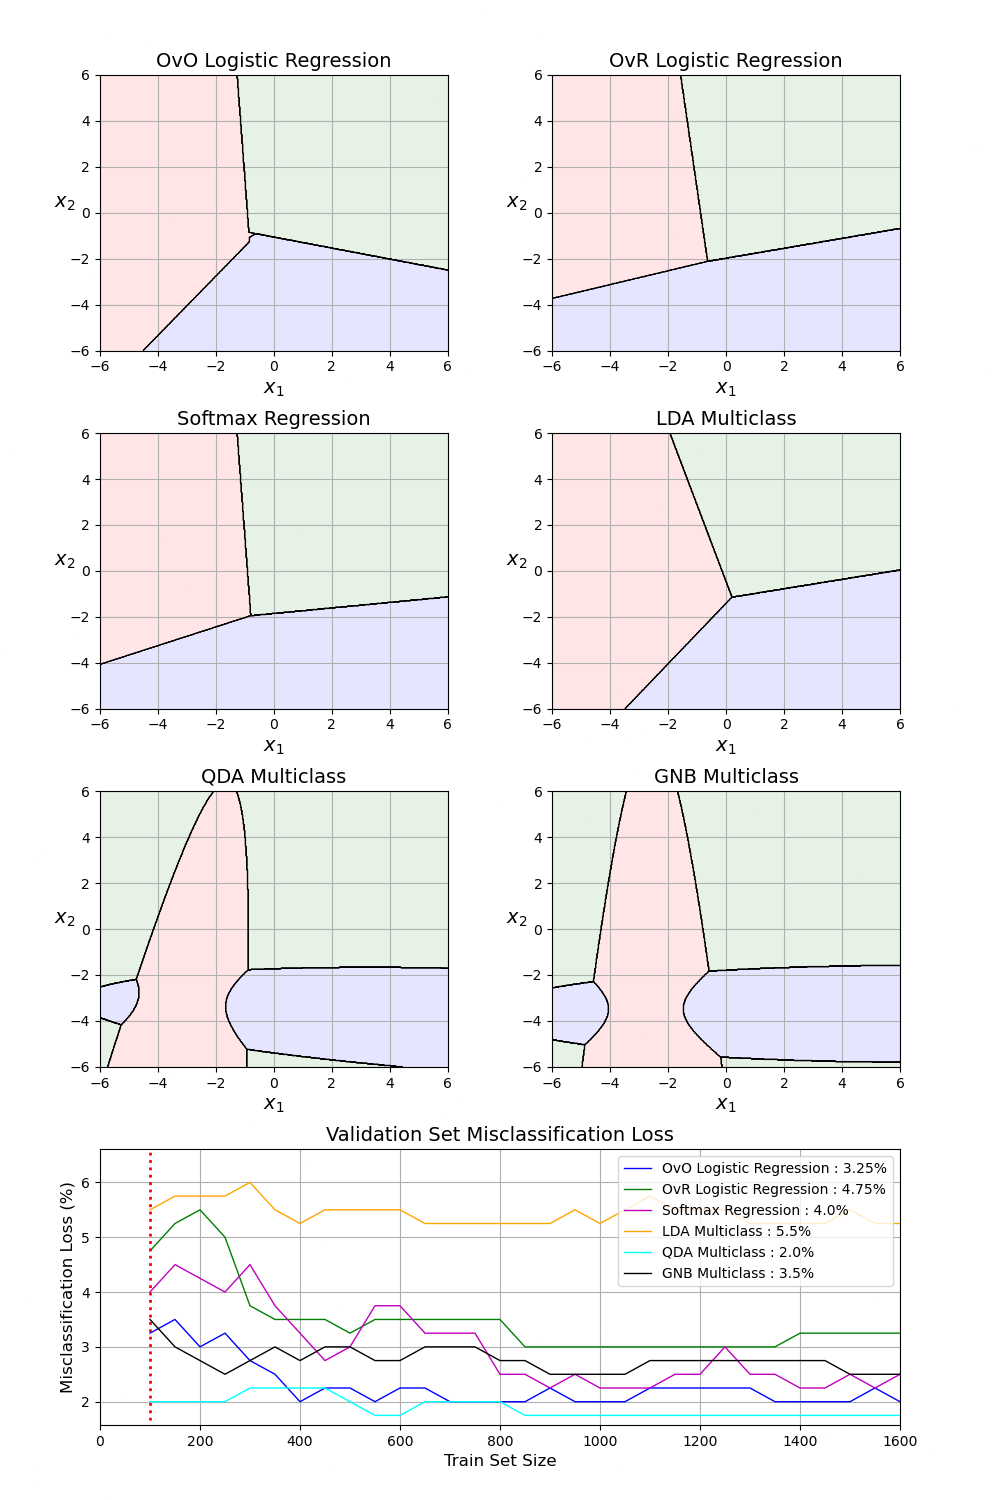

interactive(children=(Checkbox(value=False, description='Train Data'), Checkbox(value=False, description='Vali…

In [17]:
# Ex 2
#Run animated plots of the outputs
plt.close('all')
fig = plt.figure(figsize=(10,15))
plt.subplots_adjust(left=0.1,
                    bottom=0.05, 
                    right=0.9, 
                    top=0.95, 
                    hspace=0.3,
                    wspace=0.3)

gs=GridSpec(4,2) # 4 rows, 2 columns

ax1=fig.add_subplot(gs[0,0]) # First row, first column
ax2=fig.add_subplot(gs[0,1]) # First row, second column
ax3=fig.add_subplot(gs[1,0]) # Second row, first column
ax4=fig.add_subplot(gs[1,1]) # Second row, second column
ax5=fig.add_subplot(gs[2,0]) # Third row, first columns
ax6=fig.add_subplot(gs[2,1]) # Third row, second columns
ax7=fig.add_subplot(gs[3,:]) # Fourth row, span all columns

dict_names = {
                'Plot1': {
                            'model': OneVsOneClassifier(LogisticRegression(solver = 'lbfgs', penalty=None, 
                                                            fit_intercept=True, tol = 1e-9, max_iter = 100000)),
                            'label': 'OvO Logistic Regression',
                            'linestyle': 'solid',
                            'color': 'blue'
                        },
                'Plot2': {
                            'model': OneVsRestClassifier(LogisticRegression(solver = 'lbfgs', penalty=None, 
                                                            fit_intercept=True,tol = 1e-9, max_iter = 100000)),
                            'label': 'OvR Logistic Regression',
                            'linestyle': 'dashed',
                            'color': 'green'
                        },
                'Plot3': {
                            'model': LogisticRegression(multi_class='multinomial', solver = 'lbfgs', penalty=None, 
                                                        fit_intercept=True, tol = 1e-9, max_iter = 100000),
                            'label': 'Softmax Regression',
                            'linestyle': 'dotted',
                            'color': 'm'
                        },
                'Plot4': {
                            'model': LinearDiscriminantAnalysis(),
                            'label': 'LDA Multiclass',
                            'linestyle': 'dashdot',
                            'color': 'orange'
                        },
                'Plot5': {
                            'model': QuadraticDiscriminantAnalysis(),
                            'label': 'QDA Multiclass',
                            'linestyle': 'dashdot',
                            'color': 'cyan'
                        },
                'Plot6': {
                            'model': GaussianNB(),
                            'label': 'GNB Multiclass',
                            'linestyle': 'dashdot',
                            'color': 'black'
                        }}

#Set up meshgrid for contour plots
min_dist = -6
max_dist = 6
xx1, xx2 = np.meshgrid(np.linspace(min_dist, max_dist, 500),
                       np.linspace(min_dist, max_dist, 500))

def plot_Disc_Plots(checkbox_0, checkbox_1, train_size):
    
    X_train_elem = X_train[0:train_size+1,:]
    y_train_elem = y_train[0:train_size+1]

    #PLOTS 1-7:
    #Set up environments
    for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
        ax.clear()
        ax.set_xlabel('$x_1$', fontsize=14)
        ax.set_ylabel('$x_2$', fontsize=14, rotation = 0)
        ax.set_xlim(min_dist, max_dist)
        ax.set_ylim(min_dist, max_dist)
        ax.grid()

    ax7.clear()
    ax7.set_xlabel('Train Set Size', fontsize=12)
    ax7.set_ylabel('Misclassification Loss (%)', fontsize=12, rotation = 90)
    ax7.set_xlim(0, np.shape(X_train)[0])
    ax7.set_ylim(0.9*np.min(misclassification_loss), 1.1*np.max(misclassification_loss))
    ax7.grid()
    
    #PLOTS 1-6:
    #Plot training & validation data
    for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
        #Plot Training Data
        if checkbox_0 == 1:
            ax.scatter(X_train_elem[y_train_elem==0,0], X_train_elem[y_train_elem==0,1], color='green', 
                       label='$y=0$', alpha=0.3)
            ax.scatter(X_train_elem[y_train_elem==1,0], X_train_elem[y_train_elem==1,1], color='red', 
                       marker='x', label='$y=1$', alpha=0.3)
            ax.scatter(X_train_elem[y_train_elem==2,0], X_train_elem[y_train_elem==2,1], color='blue', 
                       marker='+', label='$y=2$', alpha=0.3)
            ax.legend()
        #Plot Validation Data
        if checkbox_1 == 1:
            ax.scatter(X_valid[y_valid==0,0], X_valid[y_valid==0,1], color='green', 
                       label='$y=0$', alpha=0.2)
            ax.scatter(X_valid[y_valid==1,0], X_valid[y_valid==1,1], color='red', marker='x', 
                       label='$y=1$', alpha=0.2)
            ax.scatter(X_valid[y_valid==2,0], X_valid[y_valid==2,1], color='blue', marker='+', 
                       label='$y=2$', alpha=0.2)

    #PLOT 1-7:
    i=0
    for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
        #Plot discriminants
        i=i+1
        model = dict_names['Plot'+str(i)]['model']
        label = dict_names['Plot'+str(i)]['label']
        color = dict_names['Plot'+str(i)]['color']
        linestyle = dict_names['Plot'+str(i)]['linestyle']
        model.fit(X_train_elem, y_train_elem)
        pred_fn = model.predict(np.c_[xx1.ravel(), xx2.ravel()])
        pred_fn_class = pred_fn.reshape(xx1.shape)  
        model_contour = ax.contour(xx1, xx2, pred_fn_class, colors = 'black', linewidths=0.6)
        model_contourf_y0 = ax.contourf(xx1, xx2, pred_fn_class, levels=[0,0.1], colors='green', alpha=0.1)
        model_contourf_y1 = ax.contourf(xx1, xx2, pred_fn_class, levels=[0.9,1.1], colors='red', alpha=0.1)
        model_contourf_y2 = ax.contourf(xx1, xx2, pred_fn_class, levels=[1.9,2.1], colors='blue', alpha=0.1)
        ax.set_title(label, fontsize=14)
        #Plot learning curves:
        ax7.plot(num_points_expts, misclassification_loss[:,i-1], linewidth=1, color=color, 
                 label=label + ' : ' 
                 + str(misclassification_loss[np.where(num_points_expts==train_size),i-1][0][0]) + '%')   
    ax7.vlines(x=train_size, ymin=-1, ymax=1+ax7.get_ylim()[1] ,color='red', linewidth=2, linestyle='dotted')
    ax7.legend()
    ax7.set_title('Validation Set Misclassification Loss', fontsize=14)
    
int_plot = interact(plot_Disc_Plots,
                    checkbox_0 = widgets.Checkbox(description = 'Train Data', value=False),
                    checkbox_1 = widgets.Checkbox(description = 'Validation Data', value=False),
                    train_size = widgets.IntSlider(description = 'Train Size', 
                                                   value=100, min=100, max=np.shape(X_train)[0], step=100)
                   )

plt.show()      

<div class=question>
<b>Exercise:</b>

Try changing the `Train Size` slider. What do you notice about the boundaries as the train size increases? What do you notice about the misclassification losses of each classifier? And what do you notice about how the classifiers compare to one another?


Ask youself similar questions, but with the data-generating distribution over-written such that **class imbalance** is introduced into your distributions: In particular, set the `theta_0` and `theta_1` parameters in the data generating distribution for the toy data to be $0.05$.

</div>

<div class=answer>
<b>Answer:</b>

As the train size increases the boundaries do not vary dramatically, however the validation loss tends to decrease while the most flexible boundary performs best.

As class imbalance increases more flexible boundaries become more unstable to changes in the training data. On the whole the most flexible boundaries again perform better
</div>

<a id='section_Metrics'></a>
## 4. Evaluation Metrics

### Threshold-Based Metrics

The first set of metrics involve us setting a threshold for classification (as described at the beginning of this notebook) and the recording the performance of our classifier and encoding those results within a so-called **confusion matrix**:
<table style="width:30%; font-size: 15px">
  <tr>
  <tr style="height:50px; border-bottom: solid">
    <th style="width:70%; border-right: solid"></th>
    <th style="width:70%; vertical-align:center; text-align:center; border-right: solid; border-width: thin">$y=0$</th>
    <th style="width:70%; vertical-align:center; text-align:center">$y=1$</th>
  </tr>
  <tr style="height:50px; border-bottom: solid; border-bottom-width: thin">
    <th style="width:70%; vertical-align:center; text-align:center; border-right: solid">$f(\mathbf{x})=0$</th>
    <td style="width:70%; vertical-align:center; background-color: rgba(189, 231, 189, 0.6); border-right: solid; text-align:center; border-width: thin">$TN$</td>
    <td style="width:70%; vertical-align:center; background-color: rgba(255, 182, 179, 0.6); text-align:center">$FN$</td>
  </tr>
  <tr>
  <tr style="height:50px">
    <th style="width:70%; vertical-align:center; text-align:center; border-right: solid">$f(\mathbf{x})=1$</th>
    <td style="width:70%; vertical-align:center; background-color: rgba(255, 182, 179, 0.6); text-align:center; border-right: solid; border-width: thin">$FP$</td>
    <td style="width:70%; vertical-align:center; background-color: rgba(189, 231, 189, 0.6); text-align:center">$TP$</td>
  </tr>
</table>

Where:
- TP: True Positives, i.e. those points for which the label $y=1$ and the prediction $f(\mathbf{x})=1$
- TN: True Negatives, i.e. those points for which the label $y=0$ and the prediction $f(\mathbf{x})=0$
- FP: False Positives, **Type I errors**, i.e. those points for which the label $y=0$ and the prediction $f(\mathbf{x})=1$
- FN: False Negatives, **Type II errors**, i.e. those points for which the label $y=1$ and the prediction $f(\mathbf{x})=0$


### $\bullet$ Accuracy

So far we have focused on just one metric when evaluating the validation set performance of our classifiers: **accuracy** (or rather its complement **misclassification loss**). 

Accuracy is defined as:
\begin{align*}
    \mbox{Accuracy} &= \frac{TP + TN}{TN + TP + FN + FP} \\
    \mbox{Misclassification Loss} &= \frac{FP + FN}{TN + TP + FN + FP} = 1 - \mbox{Accuracy}    
\end{align*}



Accuracy is useful when the dataset is **balanced** (i.e. the number of points for which $y=0$ is equal to the number of points for which $y=1$, but it can lead us astray in the presence of **class imbalance**. For example if the class $y=0$ is dominant, and is found in 99% of cases then a classifier which always predicts $f(\mathbf{x})$ will achieve 99% accuracy...but will always fail to predict cases when $y=0$ correctly.

Is this a problem? Perhaps not, it depends on the cost matrix associated with our problem - if $c_{10}$ is relatively small then maybe this won't be problematic.

But the trouble is that accuracy gives the same weight to both false positives and false negatives, we can remedy this by introducing the **weighted loss**


### $\bullet$  Weighted Loss

This explicitly weights false positives and false negatives according to the cost matrix:
\begin{equation*}
    \mbox{Weighted Loss} = \frac{c_{10} \times FP + c_{01} \times FN}{TN + TP + FN + FP}
\end{equation*}

But the trouble with this is that quite often we don't the settings of the cost matrix precisely.

In this case we can turn to other metrics derived from the confusion matrix:


### $\bullet$  Balanced Accuracy

This metric is defined as:

\begin{equation*}
    \mbox{Balanced Accuracy} = \frac{1}{2} \left(\frac{TP}{TP + FN} + \frac{TN}{TN + FP} \right)
\end{equation*}

It combines classifier performance on those points for which $y=0$ and those for which $y=1$ equally. 


### $\bullet$  Recall

The **recall** also known as the **sensitivity** forms part of the Balance Accuracy metric, and focuses on the **True Positive Rate** or the proportion of points for which $y=1$ that are predicted correctly:

\begin{equation*}
    \mbox{Recall} = \frac{TP}{TP + FN}
\end{equation*}


### $\bullet$  Specificity

The **specificity** forms the other part of the Balance Accuracy metric, and focuses on the **True Negative Rate** or the proportion of points for which $y=0$ that are precdicted correctly:

\begin{equation*}
    \mbox{Specificity} = \frac{TN}{TN + FP}
\end{equation*}


### $\bullet$  Precision

The **precision** also known as the **positive predicted value** is often reported alongside the recall. It focused on the proportion of points for which the prediction is $f(\mathbf{x})=1$, that are predicted correctly:

\begin{equation*}
    \mbox{Precision} = \frac{TP}{TP + FP}
\end{equation*}

### $\bullet$  Negative Predicted Value

And for completeness, the **negative predicted value** focuses on the proportion of points for which the prediction is $f(\mathbf{x})=0$, that are predicted correctly:

\begin{equation*}
    \mbox{Negative Predicted Value} = \frac{TN}{TN + FN}
\end{equation*}

### $\bullet$  F1-Score

The **F1-score** is often quoted as an aggregate measure of precision and recall - it is calculated as the harmonic mean of these two quantities:

\begin{equation*}
    \mbox{F1-score} = 2 \times \frac{\mbox{Precision} \times \mbox{Recall}}{\mbox{Precision} + \mbox{Recall}}
\end{equation*}

This measure often comes up in information retrieval tasks, but suffers in the case of class imbalance, because it ignores True Negatives.

Why do we use the harmonic rather than the simple mean when calculating this metric? Because the harmonic mean penalises extreme values more aggressively. Thus, the F1-score will favour classifiers which have similar precision and recall. Of course we don't always want this - in some circumstances we might want high precision at the cost of low recall - fraud detection might be an example of this - here it's importnant that if we extend credit to an entity then that entity should not default - in other words we want to ensure that $FP$ is low. In other circumstances we might want high recall at the cost of low precision - cancer diagnosis for referral might be an example of this case - here it's important that we capture cases where cancer really is present, even if we sometimes diagnose the absence of disease as being present - in other words we need to ensure that $FN$ is low.


Let's illustrate these metrics on some 2-dimensional imbalanced toy data.

First let's generate that data using `generate_2d_data` as usual. This time we'll split the data into Training and Validation sets using `StratifiedShuffleSplit` to ensure that the interesting class imblance in manifest in both sets of data:

In [18]:
#Generate data
#MVG parameters - for three classes
delta=0
#Class y=0
theta_0 = 0.9
sig_10 = 2
sig_20 = 2
rho_120 = 0.0
#Class y=1
sig_11 = 1.5
sig_21 = 2
rho_121 = 0.4

num_points = 5000

mu_0 = np.array([1.50,
                 1.25])
mu_1 = np.array([-1.0,
                 0.0])

sigma_0 = np.array([[sig_10**2,             rho_120*sig_10*sig_20],
                    [rho_120*sig_10*sig_20, sig_20**2]])
sigma_1 = np.array([[sig_11**2,             rho_121*sig_11*sig_21],
                    [rho_121*sig_11*sig_21, sig_21**2]])

x_0_train, x_1_train, y_0_train, y_1_train = generate_2d_data(rnd_seed=42, delta=delta, num_points=num_points,
                                                              theta_0=theta_0,
                                                              mu_0=mu_0, sigma_0=sigma_0,
                                                              mu_1=mu_1, sigma_1=sigma_1)
X = np.r_[x_0_train, x_1_train]
y = np.r_[y_0_train, y_1_train].reshape(np.shape(y_0_train)[0] + np.shape(y_1_train)[0], )
    
#Split Data into training and validation data
#NB do so in stratified fashion to preserve class imbalance in train and validation sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.8, random_state=42)
split_gen = sss.split(X, y)
train_index, valid_index = next(split_gen) 
X_train = X[train_index] 
X_valid = X[valid_index]
y_train = y[train_index] 
y_valid = y[valid_index]    

<div class=question>
<b>Exercise:</b>

Now let's evaluate the performance of Logistic Regression classifiers, trained with the Training Data, which we use to create different discriminants based off three different thresholds for $p_{\mathcal{Y}}(y=1 \vert \mathbf{x})$. We'll evaluate these classifiers using the validation set data:

1. In the cell below, insert code to plot discriminant boundaries for the classifier in the first plot in the usual way.
    
2. Insert code to plot confusion matrices which encode classifier performance on the validation set in the third plot. Use the Scikit-Learn function `confusion_matrix` in order to generate the data for this matrix.
    
3. Insert code to print evaluation metrics of the classifier performance on the validation set in the fourth plot. Use the Scikit-Learn functions `accuracy_score`, `balanced_accuracy_score`, `recall_score`, `precision_score`, and `f1_score`.
   
</div>

<IPython.core.display.Javascript object>


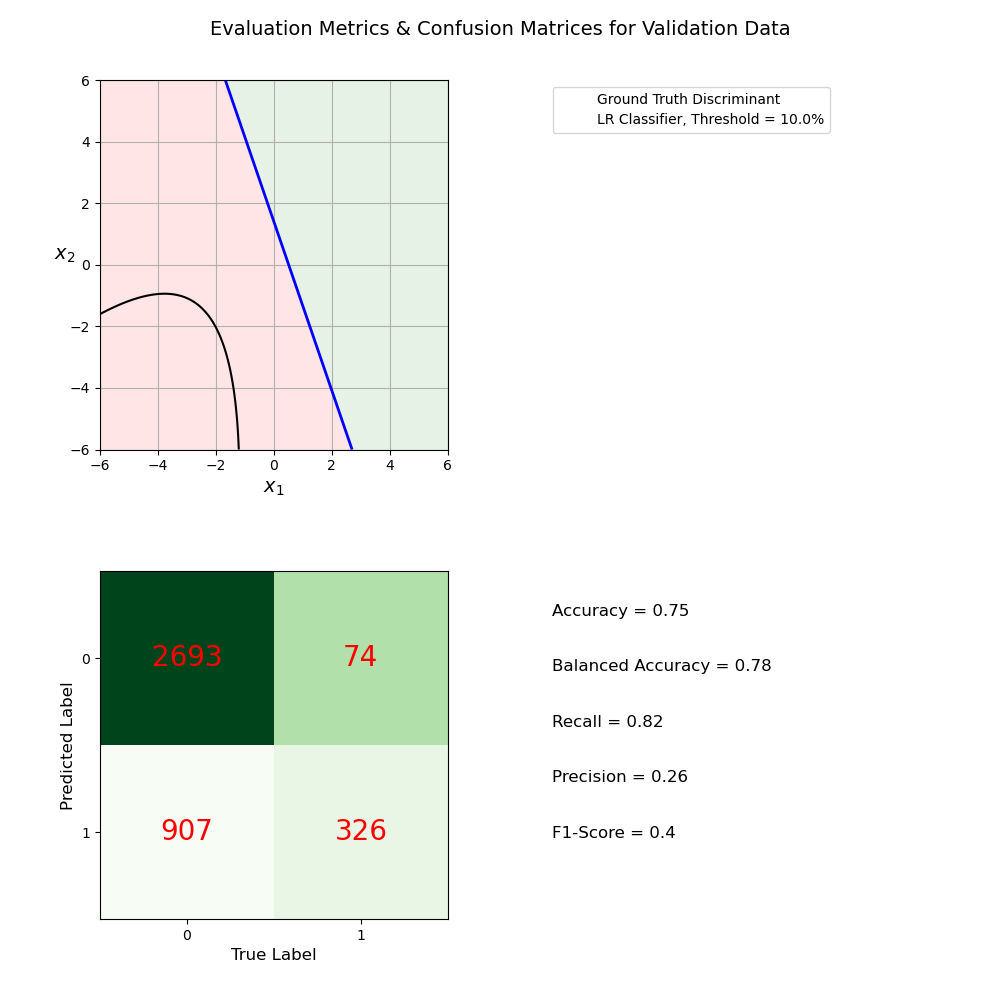

interactive(children=(Checkbox(value=False, description='Train Data'), Checkbox(value=False, description='Vali…

In [19]:
plt.close('all')
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(left=0.1,
                    bottom=0.07, 
                    right=0.9, 
                    top=0.92, 
                    hspace=0.3,
                    wspace=0.3)

gs=GridSpec(2,2) # 2 rows, 2 columns

ax1=fig.add_subplot(gs[0,0]) # First row, first column
ax2=fig.add_subplot(gs[0,1]) # First row, second column
ax3=fig.add_subplot(gs[1,0]) # Second row, first column
ax4=fig.add_subplot(gs[1,1]) # Second row, second column

lr = LogisticRegression(solver = 'lbfgs', fit_intercept=True, tol = 1e-9, max_iter = 100000)
lr.fit(X_train, y_train)

def plot_Disc_Plots(checkbox_0, checkbox_1, threshold):
    threshold = threshold/100
    
    #PLOTS 1-4:
    #Set up environments
    ax1.clear()
    ax1.set_xlabel('$x_1$', fontsize=14)
    ax1.set_ylabel('$x_2$', fontsize=14, rotation = 0)
    ax1.set_xlim(min_dist, max_dist)
    ax1.set_ylim(min_dist, max_dist)
    ax1.grid()

    ax2.clear()
    ax2.set_axis_off()

    ax3.clear()
    ax3.set_ylabel('Predicted Label', fontsize=12)
    ax3.set_xlabel('True Label', fontsize=12, rotation = 0)
    ax3.set_yticks([0,1])
    ax3.set_yticklabels([0,1])
    ax3.set_xticks([0,1])
    ax3.set_xticklabels([0,1])

    ax4.clear()
    ax4.set_axis_off()
    
    #Ex1
    #PLOT 1:
    #Plot ground truth discriminant boundary
    xx1, xx2, y_grid = generate_ground_truth(delta=delta, theta_0=theta_0, 
                                                 mu_0=mu_0, sigma_0=sigma_0, 
                                                 mu_1=mu_1, sigma_1=sigma_1)
    true_disc = ax1.contour(xx1, xx2, y_grid, [0.5], colors='black')
    true_disc.collections[0].set_label('Ground Truth Discriminant')

    #Plot classifiers discriminant boundary
    x1_plot = np.linspace(-6, 6, 500)
    x2_plot = np.linspace(-6, 6, 500)
    x1_grid, x2_grid = np.meshgrid(x1_plot, x2_plot)
    prob = lr.predict_proba(np.c_[x1_grid.ravel(), x2_grid.ravel()])
    prob = prob[:, 1].reshape(x1_grid.shape)
    lr_contour = ax1.contour(x1_grid, x2_grid, prob, levels=[threshold], colors='blue',
                            linestyles='solid', linewidths=2)
    lr_contour.collections[0].set_label('LR Classifier, Threshold = ' + str(100*round(threshold,2)) + '%')
    lr_contourf_y1 = ax1.contourf(x1_grid, x2_grid, prob, levels=[threshold,1], colors='red', alpha=0.1)
    lr_contourf_y0 = ax1.contourf(x1_grid, x2_grid, prob, levels=[0,threshold], colors='green', alpha=0.1)
    ax1.legend(bbox_to_anchor=(1.7, 1.0), loc='upper center')

    #Plot Training Data
    if checkbox_0 == 1:
        ax1.scatter(X_train[y_train==0,0], X_train[y_train==0,1], color='green', alpha=0.3)
        ax1.scatter(X_train[y_train==1,0], X_train[y_train==1,1], color='red', marker='x', alpha=0.3)

    #Plot Validation Data
    if checkbox_1 == 1:
        ax1.scatter(X_valid[y_valid==0,0], X_valid[y_valid==0,1], color='green', label='$y=0$', alpha=1)
        ax1.scatter(X_valid[y_valid==1,0], X_valid[y_valid==1,1], color='red', marker='x', label='$y=1$', alpha=1)

    ax1.legend(bbox_to_anchor=(1.7, 1.0), loc='upper center')
    
    #Ex2
    #PLOT 3:
    y_valid_prob = lr.predict_proba(X_valid)    
    cmap = 'Greens'
    y_valid_predict_LogReg = y_valid_prob[:,1]>threshold
    cm = confusion_matrix(y_valid, y_valid_predict_LogReg, labels=[0,1])
    ax3.imshow(cm, cmap=cmap)
    for r in range(2):
        for c in range(2):
            text = ax3.text(r, c, cm[r, c], ha="center", va="center", color="red", fontsize=20)

    #Ex3
    #PLOT 4:
    acc = accuracy_score(y_valid, y_valid_predict_LogReg)
    ax4.text(0,0.85,'Accuracy = '+str(round(acc,2)), fontsize = 'large')
    bal_acc = balanced_accuracy_score(y_valid, y_valid_predict_LogReg)
    ax4.text(0,0.7,'Balanced Accuracy = '+str(round(bal_acc,2)), fontsize = 'large')
    recall = recall_score(y_valid, y_valid_predict_LogReg)
    ax4.text(0,0.55,'Recall = '+str(round(recall,2)), fontsize = 'large')
    prec = precision_score(y_valid, y_valid_predict_LogReg)
    ax4.text(0,0.4,'Precision = '+str(round(prec,2)), fontsize = 'large')
    f1 = f1_score(y_valid, y_valid_predict_LogReg)
    ax4.text(0,0.25,'F1-Score = '+str(round(f1,2)), fontsize = 'large')
                      
int_plot = interact(plot_Disc_Plots,
                    checkbox_0 = widgets.Checkbox(description = 'Train Data', value=False),
                    checkbox_1 = widgets.Checkbox(description = 'Validation Data', value=False),
                    threshold = widgets.FloatSlider(description = 'Threshold %', 
                                                   value=10, min=0.001, max=100, step=5)
                   )

fig.suptitle('Evaluation Metrics & Confusion Matrices for Validation Data', fontsize=14)
    
plt.show()      

<div class=question>
<b>Exercise:</b>

What do you notice about how the metrics vary as classification boundaries move?
    
In particular, do all metrics agree on improved or diminished performance?
</div>

<div class=answer>
<b>Answer:</b>

The accuracy and balanced accuracy, and the precision and recall tend to move in opposite directions, one trading of against the other as the boundary moves.
    
</div>

### Threshold-Free Metrics

The metrics discussed so far require uys to specify a threshold in order to generate a particular classifier. But if we are unsure of the threshold, or rather if we would like to re-purpose our probabilistic classifier for different tasks which might involve different hurdle rates, then we might be interested in evaluating the classifier performance over a range of thresholds. In this section we examine the best known of such **threshold-free metrics**.

It should be noted that these metrics are only useful if we _can_ vary the threshold! In what follows for probabilistic classifiers we'll use the posterior probability ($p_{\mathcal{Y}}(y=1 \vert \mathbf{x})$) as our threshold. But it's worth noting that we don't have access to such a metric for discriminant classifiers. In some cases, such as the Support Vector Machine, we can come up with a sensible proxy, based around distance from the discrimiant function learned when the algorithm is run, but in other cases, such as the Decision Tree, these proxies are not so clear.


### $\bullet$ Precision-Recall Curve

The **Precision-Recall Curve** (PR curve) is generated by plotting the precision against the recall for every different thresholds. Roughly, as the recall decreases, the precision will increase, however, while the recall is monotonic in threshold changes, the precision is not: while it is always the case that the denominator of the recall remains fixed, and the count of $TP$ is of course monotonic in the threshold level; for the precision the denominator will always decrease (or stay the same) as the threshold increases, but sometimes this will be as a result of the $TP$ count diminishing more than the $FN$ count. On these occasions the precision can decrease.

'Better' classifier types are those which hug the top and right hand side of the PR-curve plotting grid. We can use the PR curve to help us pick the best classifier for a given precision (or recall) tolerance.

### $\bullet$ Receiver Operating Characteristic (ROC)

The **Receiver Operating Characteristic** (ROC) curve is generated by plotting the True Positive Rate ($\frac{TP}{TP+FN}$) against the False Positive Rate ($\frac{FP}{TN+FP}$). Each is montonic in the hurdle rate.

'Better classifier types are those which hug the top and left hand side of the ROC curve plotting grid, with completely random classifiers resulting in a curve which traces out a diagonal line on the plot from $(0,0)$ to $(1,1)$. We can use the ROC curve to help us pick the best classifier for a given TPR (or FPR) tolerance.

### $\bullet$ Area Under Curve (AUC)

We can summarise the ROC curve with one number: the **Area Under Curve** (AUC). This is simply the area under the ROC curve. The best possible value for the AUC is $1$, while a random classifer would give an AUC value of $0.5$.


Both the PR and ROC curves express a trade off in classification performance - when should we use each? Geron suggests a rule of thumb: The PR curve should be used when the $y=1$ calss is rare or when you are more interested in the $FP$ count than the $FN$ count. Otherwise the ROC curve should be used. Why? Consider the case when there are few $y=1$ points. In this case for very low thresholds the TPR is inclined to be much higher than the FPR. However this is really to be expected - more should be expected of a 'good' classifier set in this situation (i.e.the ROC curve could be even closer to the top left hand part of the grid). But this is made more apparent by looking at the PR curve which is not so influenced by class imblance skewed towards $y=0$ points because the presence of $FP$ in the denominator of the precision means that this value will be heavily penalised if the classifier doe snot perform well on the larger $y=0$ class. 


Now let's illustrate these metrics using the same data and the same Logistic Regression classifier(s) that we used in the Threshold-Based metrics case:

<div class=question>
<b>Exercise:</b>

Below we include code for plotting the discriminants and confusion matrix as before. You should generate three other annoted plots:
    
1. Use `precision_recall_curve` to generate precision and recall values, evaluated on the validation set for different thresholds. Use the `predict_proba` method on the validation data in order generate a set of hurdle rates. (Note that Scikit-Learn uses these hurdle rates as a set of `thresholds` and then calculates the precision and recall for each setting of these thresholds). These values are then used to plot both the precision and the recall against the thresholds.
    
2. Use the values of `precisions` and `recalls` just generated to plot a PR curve. 
    
3. Use `roc_curve`, with `drop_intermediate=False`, to generate FPR and TPR values, evaluated on the validation set for different thresholds. Use the `predict_proba` method on the validation data in order generate a set of hurdle rates as before. Use the values of `tpr` and `fpr` generated to plot an ROC curve.
    
4. Use `roc_auc_score` to print the AUC score on the ROC curve plot.
</div>

<IPython.core.display.Javascript object>


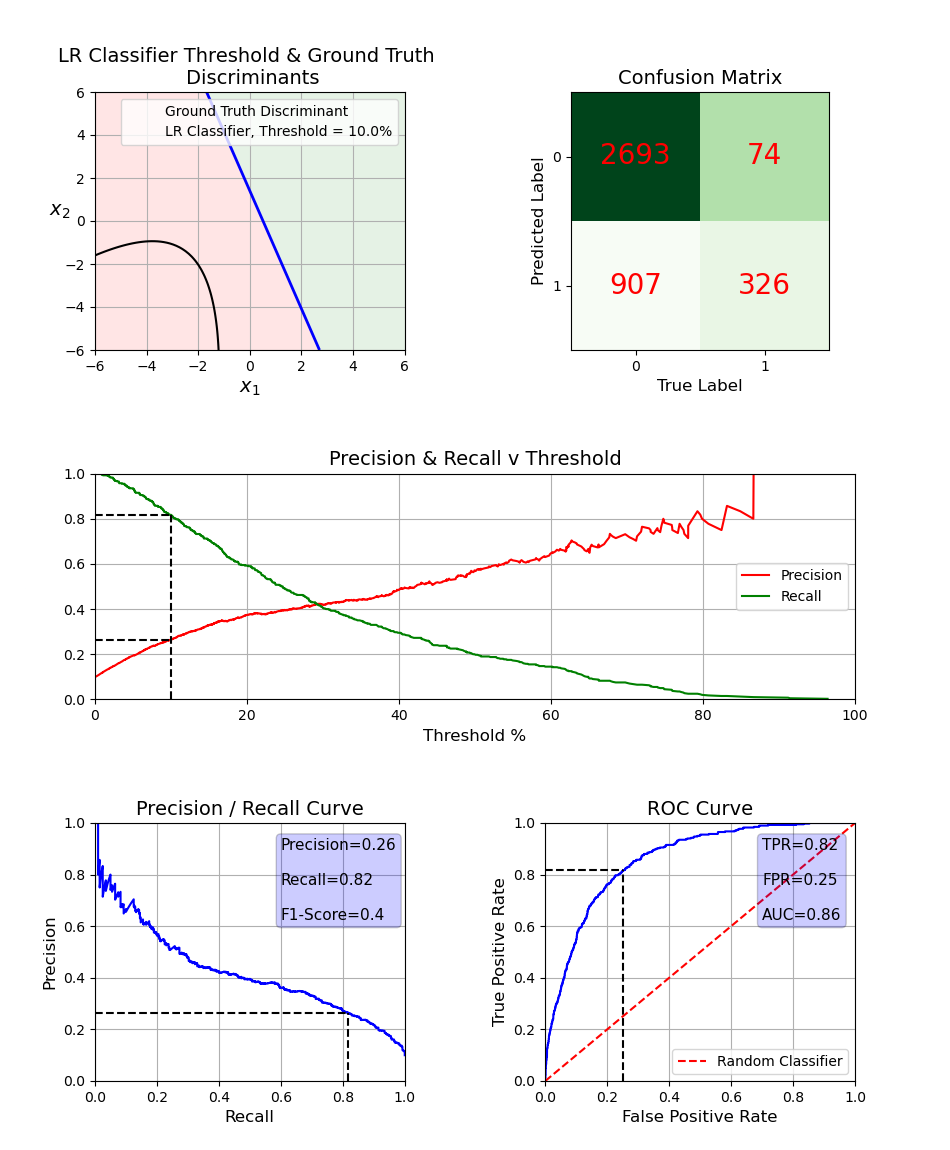

interactive(children=(Checkbox(value=False, description='Train Data'), Checkbox(value=False, description='Vali…

In [20]:
plt.close('all')

fig = plt.figure(figsize=(9.5,11.5))
plt.subplots_adjust(left=0.1,
                    bottom=0.06, 
                    right=0.9, 
                    top=0.92, 
                    hspace=0.5,
                    wspace=0.5)

gs=GridSpec(3,5, height_ratios=[4,3.5,4], width_ratios=[2,2,0.5,2,2]) # 4 rows, 3 columns

ax1=fig.add_subplot(gs[0,0:2]) # First row
ax15=fig.add_subplot(gs[0,3:5]) # First row
ax2=fig.add_subplot(gs[1,:]) # Second row
ax3=fig.add_subplot(gs[2,0:2]) # Third row, first column
ax4=fig.add_subplot(gs[2,3:5]) # Third row, second column

lr = LogisticRegression(solver = 'lbfgs', fit_intercept=True, tol = 1e-9, max_iter = 100000)
lr.fit(X_train, y_train)

def plot_Disc_Plots(checkbox_0, checkbox_1, threshold):
    threshold = threshold/100
    
    #PLOTS 1-4:
    #Set up environments
    ax1.clear()
    ax1.set_xlabel('$x_1$', fontsize=14)
    ax1.set_ylabel('$x_2$', fontsize=14, rotation = 0)
    ax1.set_xlim(min_dist, max_dist)
    ax1.set_ylim(min_dist, max_dist)
    ax1.grid()

    ax15.clear()
    ax15.set_ylabel('Predicted Label', fontsize=12)
    ax15.set_xlabel('True Label', fontsize=12, rotation = 0)
    ax15.set_yticks([0,1])
    ax15.set_yticklabels([0,1])
    ax15.set_xticks([0,1])
    ax15.set_xticklabels([0,1])

    ax2.clear()
    ax2.set_xlabel('Threshold %', fontsize=12)
    ax2.set_xlim(0, 100)
    ax2.set_ylim(0, 1)
    ax2.grid()
    
    ax3.clear()
    ax3.set_xlabel('Recall', fontsize=12)
    ax3.set_ylabel('Precision', fontsize=12, rotation = 90)
    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)
    ax3.grid()

    ax4.clear()
    ax4.set_xlabel('False Positive Rate', fontsize=12)
    ax4.set_ylabel('True Positive Rate', fontsize=12, rotation = 90)
    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)
    ax4.grid()

    #PLOT 1:
    #Plot ground truth discriminant boundary
    xx1, xx2, y_grid = generate_ground_truth(delta=delta, theta_0=theta_0, 
                                                 mu_0=mu_0, sigma_0=sigma_0, 
                                                 mu_1=mu_1, sigma_1=sigma_1)
    true_disc = ax1.contour(xx1, xx2, y_grid, [0.5], colors='black')
    true_disc.collections[0].set_label('Ground Truth Discriminant')

    #Plot classifiers discriminant boundary
    x1_plot = np.linspace(-6, 6, 500)
    x2_plot = np.linspace(-6, 6, 500)
    x1_grid, x2_grid = np.meshgrid(x1_plot, x2_plot)
    prob = lr.predict_proba(np.c_[x1_grid.ravel(), x2_grid.ravel()])
    prob = prob[:, 1].reshape(x1_grid.shape)
    lr_contour = ax1.contour(x1_grid, x2_grid, prob, levels=[threshold], colors='blue',
                            linestyles='solid', linewidths=2)
    lr_contour.collections[0].set_label('LR Classifier, Threshold = ' + str(100*round(threshold,2)) + '%')
    lr_contourf_y1 = ax1.contourf(x1_grid, x2_grid, prob, levels=[threshold,1], colors='red', alpha=0.1)
    lr_contourf_y0 = ax1.contourf(x1_grid, x2_grid, prob, levels=[0,threshold], colors='green', alpha=0.1)
    ax1.legend(bbox_to_anchor=(1.7, 1.0), loc='upper center')

    #Plot Training Data
    if checkbox_0 == 1:
        ax1.scatter(X_train[y_train==0,0], X_train[y_train==0,1], color='green', alpha=0.3)
        ax1.scatter(X_train[y_train==1,0], X_train[y_train==1,1], color='red', marker='x', alpha=0.3)

    #Plot Validation Data
    if checkbox_1 == 1:
        ax1.scatter(X_valid[y_valid==0,0], X_valid[y_valid==0,1], color='green', label='$y=0$', alpha=1)
        ax1.scatter(X_valid[y_valid==1,0], X_valid[y_valid==1,1], color='red', marker='x', label='$y=1$', alpha=1)
    
    ax1.set_title('LR Classifier Threshold & Ground Truth \n Discriminants', fontsize=14)
    ax1.legend()

    #PLOT 15:
    y_valid_prob = lr.predict_proba(X_valid)    
    cmap = 'Greens'
    y_valid_predict_LogReg = y_valid_prob[:,1]>threshold
    cm = confusion_matrix(y_valid, y_valid_predict_LogReg, labels=[0,1])
    ax15.imshow(cm, cmap=cmap)
    for r in range(2):
        for c in range(2):
            text = ax15.text(r, c, cm[r, c], ha="center", va="center", color="red", fontsize=20)
    ax15.set_title('Confusion Matrix', fontsize=14)

    #Ex1
    #PLOT 2:
    y_valid_prob = lr.predict_proba(X_valid)
    precisions, recalls, thresholds = precision_recall_curve(y_valid, y_valid_prob[:,1])
    ax2.plot(100*thresholds, precisions[:-1], color='red', label='Precision')
    ax2.plot(100*thresholds, recalls[:-1], color='green', label='Recall')
    ax2.plot([min_dist,0], [0.5,0.5] ,color='black', linestyle='dashed')
    #function to find closest value in a list
    def closest(lst, K):
        return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
    index_threshold = np.where(thresholds == closest(thresholds, threshold))[0][0]
    ax2.plot([0,thresholds[index_threshold]*100], [recalls[index_threshold],recalls[index_threshold]],
             color='black', linestyle='dashed', linewidth=1.5)
    ax2.plot([0,thresholds[index_threshold]*100], [precisions[index_threshold],precisions[index_threshold]],
             color='black', linestyle='dashed', linewidth=1.5)
    ax2.vlines(x=thresholds[index_threshold]*100, ymin=0,
               ymax=max(recalls[index_threshold], precisions[index_threshold]), 
               color='black', linestyle='dashed', linewidth=1.5)
    ax2.legend(loc='right')
    ax2.set_title('Precision & Recall v Threshold', fontsize=14)

    #Ex2
    #PLOT 3:
    ax3.plot(recalls, precisions, color='blue')
    ax3.plot([0,recalls[index_threshold]], [precisions[index_threshold],precisions[index_threshold]],
             color='black', linestyle='dashed', linewidth=1.5)
    ax3.vlines(x=recalls[index_threshold], ymin=0, ymax=precisions[index_threshold], 
               color='black', linestyle='dashed', linewidth=1.5)
    ax3.set_title('Precision / Recall Curve', fontsize=14)
    #Mark on text:
    props = dict(boxstyle='round', alpha=0.5)
    prec = precisions[index_threshold]
    recall = recalls[index_threshold]
    f1 = 2*prec*recall/(prec+recall)
    textstr = '\n'.join((
        r'Precision='+str(round(prec,2)),
        '',
        r'Recall='+str(round(recall,2)),
        '',
        r'F1-Score='+str(round(f1,2)) ))
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='blue', alpha=0.2)
    ax3.text(0.05, 0.95, textstr, fontsize=11, position=(0.6,0.94),
            verticalalignment='top', horizontalalignment='left', bbox=props)

    #Ex3
    #PLOT 4:
    y_valid_prob = lr.predict_proba(X_valid)
    fpr, tpr, thresholds = roc_curve(y_valid, y_valid_prob[:,1],drop_intermediate=False)
    index_threshold = np.where(thresholds == closest(thresholds, threshold))[0][0]
    ax4.plot(fpr, tpr, color='blue')
    ax4.plot([0,fpr[index_threshold]], [tpr[index_threshold],tpr[index_threshold]],
             color='black', linestyle='dashed', linewidth=1.5)    
    ax4.vlines(x=fpr[index_threshold], ymin=0, ymax=tpr[index_threshold], 
               color='black', linestyle='dashed', linewidth=1.5)
    #Plot random classifier curve
    ax4.plot([0,1], [0,1], color='red', linestyle='dashed', linewidth=1.5, label='Random Classifier')
    ax4.legend()
    ax4.set_title('ROC Curve', fontsize=14)
    #Mark on text:
    props = dict(boxstyle='round', alpha=0.5)
    TPR = tpr[index_threshold]
    FPR = fpr[index_threshold]
    AUC = roc_auc_score(y_valid, y_valid_prob[:,1])
    textstr = '\n'.join((
        r'TPR='+str(round(TPR,2)),
        '',
        r'FPR='+str(round(FPR,2)),
        '',
        r'AUC='+str(round(AUC,2))
    ))
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='blue', alpha=0.2)
    ax4.text(0.05, 0.95, textstr, fontsize=11, position=(0.7,0.94),
            verticalalignment='top', horizontalalignment='left', bbox=props)

        
int_plot = interact(plot_Disc_Plots,
                    checkbox_0 = widgets.Checkbox(description = 'Train Data', value=False),
                    checkbox_1 = widgets.Checkbox(description = 'Validation Data', value=False),
                    threshold = widgets.FloatSlider(description = 'Threshold %', 
                                                   value=10, min=0.001, max=100, step=5)
                   )
    
plt.show()      

<div class=question>
<b>Exercise:</b>

As before vary the the threshold / class boundary. 
    
Notice how the Precision \& Recall and the TPR \& FPR trade off against one another. Note that while the TPR and FPR move montonically with the threshold, the Precision does not.
</div>

<a id='section_Imbalance'></a>
## 5. Data Imbalance

There are two types of data imbalance: **cost imbalance** and **class imbalance**.

Cost imbalance becomes manifest when $c_{01} \neq c_{10}$ in the cost matrix: The exercises throughout the [**Evaluation Metrics**](#section_Metrics) (where setting the threshold was a proxy for altering the cost matrix) demonstrated that cost imbalance can often cause classification algorithms to assess different classifiers very differently.

Class imbalance becomes manifest when the number of $y=0$ data points does not equal the number of $y=1$ data points: The exercise at the end of the [**Multinomial Classification**](#section_MultinomialClassification) section demonstrated that class imbalance can often cause classification algorithms to learn very different classifiers.

But while these problems are related - because they become manifest when using common evaluation metrics - they are both distinct.

Proposals on how one should address these problems are varied in the literature, so please be aware that in what follows I am advancing an approach that I deem sensible. But you should not assume that this is uncontroversial (or that it is novel)!

I am going to argue that cost imbalance should be accounted for _after_ the learning phase, when one makes a classification decision. However, I should mention that Scikit-learn allows one to weight examples from each class differently in the learning phase for certain of its learning algorithms via the `class_weight` flag that one can set when calling various classifiers. This is sometimes used to 'correct' for cost imbalance.

I am going to argue that class imbalance may not need to be corrected for at all, depending on the amount of data that is available and the classification algorithm that is being used. However, again, I should mention that there exists another Python package, [Imbalanced Learn](https://imbalanced-learn.org/stable/), that contains various under and over sampling routines that one can use to generate a synthetically balanced data set (see for example `RandomUnderSampler`, `RandomOverSampler`, `SMOTE`).

### Is Class Imbalance a Problem?

This is a controversial matter, but it is plausible to argue that it's not so much the _relative_ rarity of a particular class that's important as the _absolute_ rarity of that class. In other words class imbalance is fine so long as we have a large enough amount of data. See this [article](https://statisticalhorizons.com/logistic-regression-for-rare-events/) and this [post](https://stats.stackexchange.com/questions/357466/are-unbalanced-datasets-problematic-and-how-does-oversampling-purport-to-he) for a discussion of these points. In a nutshell, the argument is that class imbalance is a facet of certain datasets that should not be synthetically eradicated. It needs to be modelled, directly or indirectly. Indeed, in generative approaches to classification we do exactly this when we try to estimate $p_{\mathcal{Y}}(y=1)$.

So what should we do if we encounter data imbalance? One view is that we should do nothing unless the absolute size of the minority class is too small for patterns to be detected. 

How small is too small? This depends on the particular problem, but the article above suggests less than between 20 and 200 as a rule of thumb.

And what should we do if the minority class is too small? For Logistic Regression we could try making the small sample correction which [King \& Zeng](https://gking.harvard.edu/files/gking/files/0s.pdf) discuss, or we could attempt to address the problem in another fashion by using **anomaly detection**. We won't discuss anomaly detection here, but the idea is that we only seek to model the characteristics of the majority class. Whatever pattern we learn is used to judge whether a new data point is a member of that class. If it isn't, it's assumed to be a member of the other class. But we have done all of this without using the small (and hence potentially misleading) amount of minority class data to model anything.

### How do we address Cost Imbalance?

When deploying the classifier in a particular setting, with a well-defined cost matrix, then it makes sense to use this cost matrix to inform a decision threshold which should be used in order to make a decision by comparing it against a measure appropriate to the type of classifier under consideration.

For probabilistic classifiers this threshold can be constructed straightforwardly (recall that we stated earlier that it should be set at $\frac{c_{10}}{c_{10} + c_{01}}$) to be one which can be compared with the value of $p_{\mathcal{Y}}(y=1 \vert \mathbf{x})$ output by the classifier.

Thus depending on the cost matrix the same trained classifier can be deployed in a variety of ways.

For discriminant classifiers, such as the SVM or Decision Trees, then mapping the cost matrix onto some threshold is often not straightforward. For these classifiers then one can attempt to build cost into the classification algorithm itself (one can view the use of the `class_weight` flag as an approach to this), but we will not dicuss this further here.

### Evaluation Revisited

If we have a clear cost matrix and a probabilistic classifier then evaluation becomes more strightforward, even in the presence of class imbalance - simply make use of a Weigthed Loss measure synthesised from the cost matrix.

Ultimately, when a classifier is used in practice then such a cost matrix must be specified somehow, but in those instances where a classifier is built before this is known then we should use the range of tools discussed in [**Evaluation Metrics**](#section_Metrics) - in particular the Threshold-Free metrics.







